Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
MUSICAL NOTE DETECTION SYSTEM

[1] Loading DeepScores V2 dataset...
[Loader] Dataset path: /content/drive/MyDrive/ds2_dense
[Loader] Images path: /content/drive/MyDrive/ds2_dense/images
[Loader] Annotation file: /content/drive/MyDrive/ds2_dense/deepscores_train.json

[2] Building dataset...
[Dataset] Loading annotations...
[Loader] Loading annotations from deepscores_train.json...
[Loader] Found 168 unique categories
[Loader] Total annotations: 889833
[Loader] Filtered to 322631 note/accidental annotations
[Dataset] Found 322631 relevant annotations
[Dataset] Limited to 2000 annotations
[Dataset] Loaded 1362 unique images
[Dataset] Successfully processed: 2000 annotations
[Dataset] Skipped: 0 annotations
[Dataset] Final shape: X=(2000, 32, 32, 1), y=(2000,)

Dataset class distribution:
  note: 1798 samples
  sharp: 100 samples
  flat: 78 samples
  natural: 24

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 618,758 (2.36 MB)

 Trainable params: 618,758 (2.36 MB)

 Non-trainable params: 0 (0.00 B)


[4] Training model...
[Train] Training set: (1600, 32, 32, 1)
[Train] Test set: (400, 32, 32, 1)
Epoch 1/8
50/50 - 6s - 112ms/step - accuracy: 0.8813 - loss: 0.5519 - val_accuracy: 0.8975 - val_loss: 0.4373
Epoch 2/8
50/50 - 5s - 97ms/step - accuracy: 0.8994 - loss: 0.4572 - val_accuracy: 0.8975 - val_loss: 0.4480
Epoch 3/8
50/50 - 3s - 63ms/step - accuracy: 0.8994 - loss: 0.4546 - val_accuracy: 0.8975 - val_loss: 0.4274
Epoch 4/8
50/50 - 5s - 104ms/step - accuracy: 0.8994 - loss: 0.4483 - val_accuracy: 0.8975 - val_loss: 0.4278
Epoch 5/8
50/50 - 6s - 115ms/step - accuracy: 0.8994 - loss: 0.4298 - val_accuracy: 0.8975 - val_loss: 0.4172
Epoch 6/8
50/50 - 4s - 88ms/step - accuracy: 0.8994 - loss: 0.4281 - val_accuracy: 0.8975 - val_loss: 0.4632
Epoch 7/8
50/50 - 3s - 64ms/step - accuracy: 0.8994 - loss: 0.4063 - val_accuracy: 0.8975 - val_loss: 0.4051
Epoch 8/8
50/50 - 5s - 109ms/step - accuracy: 0.8994 - loss: 0.3641 - val_accuracy: 0.8975 - val_loss: 0.3807
13/13 ━━━━━━━━━━━━━━━━━━━━

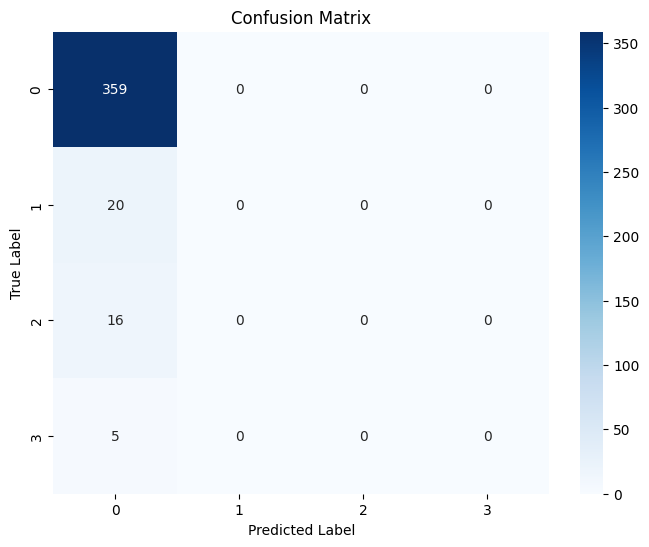


[Train] Model saved to /content/drive/MyDrive/note_detector_tf.h5


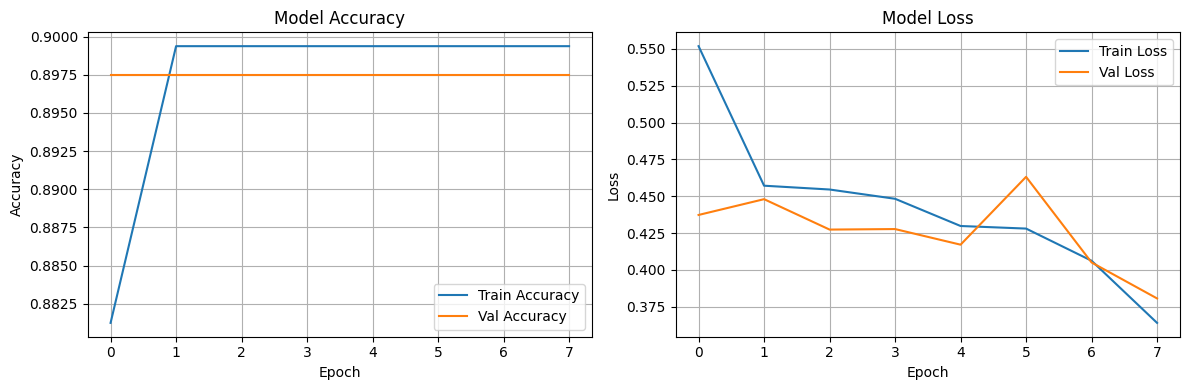


TRAINING COMPLETE!


In [ ]:
!pip install tensorflow scikit-learn seaborn matplotlib opencv-python-headless

import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')


class DeepScoresLoader:
    """Loads and parses DeepScores V2 dataset"""

    def __init__(self, dataset_path, split="train"):
        self.dataset_path = Path(dataset_path)
        self.split = split

        # Define paths - images are directly in the images folder
        self.images_path = self.dataset_path / "images"
        self.annotation_file = self.dataset_path / f"deepscores_{split}.json"

        # Define note classes we're interested in
        self.note_classes = {
            # Black noteheads (quarter notes, eighth notes, etc.)
            'noteheadBlackInSpace': 'note',
            'noteheadBlackOnLine': 'note',
            'noteheadBlackInSpaceSmall': 'note',
            'noteheadBlackOnLineSmall': 'note',
            'noteheadFullSmall': 'note',
            # Half notes
            'noteheadHalfInSpace': 'note',
            'noteheadHalfOnLine': 'note',
            'noteheadHalfInSpaceSmall': 'note',
            'noteheadHalfOnLineSmall': 'note',
            'noteheadHalfSmall': 'note',
            # Whole notes
            'noteheadWhole': 'note',
            'noteheadWholeInSpace': 'note',
            'noteheadWholeOnLine': 'note',
            'noteheadWholeInSpaceSmall': 'note',
            'noteheadWholeOnLineSmall': 'note',
            # Double whole notes (breves)
            'noteheadDoubleWholeInSpace': 'note',
            'noteheadDoubleWholeOnLine': 'note',
            'noteheadDoubleWholeInSpaceSmall': 'note',
            'noteheadDoubleWholeOnLineSmall': 'note',
            # Accidentals
            'accidentalSharp': 'sharp',
            'accidentalSharpSmall': 'sharp',
            'accidentalFlat': 'flat',
            'accidentalFlatSmall': 'flat',
            'accidentalNatural': 'natural',
            'accidentalNaturalSmall': 'natural',
            'accidentalDoubleSharp': 'double_sharp',
            'accidentalDoubleFlat': 'double_flat',
            # Key signatures
            'keySharp': 'sharp',
            'keyFlat': 'flat',
            'keyNatural': 'natural',
        }

        print(f"[Loader] Dataset path: {self.dataset_path}")
        print(f"[Loader] Images path: {self.images_path}")
        print(f"[Loader] Annotation file: {self.annotation_file}")

        # Verify paths exist
        if not self.images_path.exists():
            raise FileNotFoundError(f"Images directory not found: {self.images_path}")
        if not self.annotation_file.exists():
            raise FileNotFoundError(f"Annotation file not found: {self.annotation_file}")

    def load_annotations(self):
        """Load annotations from the main JSON file"""
        if not self.annotation_file.exists():
            raise FileNotFoundError(f"Annotation file not found: {self.annotation_file}")

        print(f"[Loader] Loading annotations from {self.annotation_file.name}...")
        with open(self.annotation_file, 'r') as f:
            return json.load(f)

    def get_note_annotations(self, annotations):
        """Filter annotations to only include musical notes and accidentals"""
        filtered = []

        cat_id_to_name = {}
        if 'categories' in annotations:
            categories = annotations['categories']
            if isinstance(categories, dict):
                for cat_id, cat_info in categories.items():
                    if isinstance(cat_info, dict):
                        cat_name = cat_info.get('name', '')
                        cat_id_to_name[str(cat_id)] = cat_name
                        cat_id_to_name[int(cat_id)] = cat_name
                    elif isinstance(cat_info, str):
                        cat_id_to_name[str(cat_id)] = cat_info
                        cat_id_to_name[int(cat_id)] = cat_info

        print(f"[Loader] Found {len(set(cat_id_to_name.values()))} unique categories")

        anns = annotations.get('annotations', {})
        if isinstance(anns, dict):
            ann_list = list(anns.values())
        else:
            ann_list = anns

        print(f"[Loader] Total annotations: {len(ann_list)}")

        for ann in ann_list:
            cat_ids = ann.get('cat_id', [])
            if not isinstance(cat_ids, list):
                cat_ids = [cat_ids]

            # Check each category in the annotation
            for cat_id in cat_ids:
                if cat_id in cat_id_to_name:
                    cat_name = cat_id_to_name[cat_id]
                    if cat_name in self.note_classes:
                        ann_copy = ann.copy()
                        ann_copy['symbol_type'] = self.note_classes[cat_name]
                        ann_copy['category_id'] = cat_id
                        filtered.append(ann_copy)
                        break

        print(f"[Loader] Filtered to {len(filtered)} note/accidental annotations")
        return filtered


class NoteDataset:
    """Builds training data for note/accidental detection"""

    def __init__(self, loader, input_size=32):
        self.loader = loader
        self.input_size = input_size

        self.label_to_idx = {
            'note': 0,
            'sharp': 1,
            'flat': 2,
            'natural': 3,
            'double_sharp': 4,
            'double_flat': 5
        }
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        self.classes = list(self.label_to_idx.keys())

    def extract_crop(self, image, bbox):
        """Extract and resize crop from bounding box"""
        x, y, w, h = map(int, bbox)

        # Ensure coordinates are valid
        x = max(0, x)
        y = max(0, y)

        # Extract crop
        crop = image[y:y+h, x:x+w]

        # Skip invalid crops
        if crop.size == 0 or crop.shape[0] < 1 or crop.shape[1] < 1:
            return None

        # Resize to fixed size
        crop = cv2.resize(crop, (self.input_size, self.input_size))
        return crop

    def build(self, max_annotations=None, shuffle=True, verbose=True):
        """Build dataset from the main annotation file"""

        if verbose:
            print(f"[Dataset] Loading annotations...")

        # Load the single annotation file
        annotations = self.loader.load_annotations()
        note_anns = self.loader.get_note_annotations(annotations)

        if verbose:
            print(f"[Dataset] Found {len(note_anns)} relevant annotations")

        # Limit annotations if specified
        if max_annotations:
            note_anns = note_anns[:max_annotations]
            if verbose:
                print(f"[Dataset] Limited to {len(note_anns)} annotations")

        img_id_to_filename = {}
        if 'images' in annotations:
            images = annotations['images']
            if isinstance(images, dict):
                for img_id, img_info in images.items():
                    if isinstance(img_info, dict):
                        filename = img_info.get('filename', img_info.get('file_name', ''))
                        # Store both string and int versions
                        img_id_to_filename[str(img_id)] = filename
                        img_id_to_filename[int(img_id)] = filename
            elif isinstance(images, list):
                for img in images:
                    img_id = img.get('id')
                    filename = img.get('filename', img.get('file_name', ''))
                    # Store both string and int versions
                    img_id_to_filename[str(img_id)] = filename
                    img_id_to_filename[int(img_id)] = filename

        if verbose:
            print(f"[Dataset] Loaded {len(set(img_id_to_filename.values()))} unique images")

        X = []
        y = []
        processed = 0
        skipped = 0

        for ann in note_anns:
            image_id = ann.get('img_id', ann.get('image_id'))
            if image_id not in img_id_to_filename:
                skipped += 1
                continue

            image_filename = img_id_to_filename[image_id]
            image_path = self.loader.images_path / image_filename

            # Load image
            if not image_path.exists():
                skipped += 1
                continue

            img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
            if img is None:
                skipped += 1
                continue

            bbox = ann.get('a_bbox', ann.get('bbox'))
            if bbox is None:
                skipped += 1
                continue

            crop = self.extract_crop(img, bbox)
            if crop is None:
                skipped += 1
                continue

            X.append(crop)
            y.append(self.label_to_idx.get(ann.get('symbol_type', 'note'), 0))
            processed += 1

        # Convert to numpy arrays
        X = np.array(X).reshape(-1, self.input_size, self.input_size, 1)
        y = np.array(y, dtype=np.int32)

        # Shuffle if requested
        if shuffle:
            idx = np.random.permutation(len(X))
            X, y = X[idx], y[idx]

        if verbose:
            print(f"[Dataset] Successfully processed: {processed} annotations")
            print(f"[Dataset] Skipped: {skipped} annotations")
            print(f"[Dataset] Final shape: X={X.shape}, y={y.shape}")

        return X, y


class NotePreprocessor:
    """Image preprocessing utilities for musical notation"""

    @staticmethod
    def apply_threshold(image, threshold=127):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
        _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
        return binary

    @staticmethod
    def remove_staff_lines(image):
        """Remove staff lines from sheet music"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

        # Detect horizontal lines (staff lines)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (25, 1))
        detected_lines = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)

        # Create binary images
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        _, lines_binary = cv2.threshold(detected_lines, 127, 255, cv2.THRESH_BINARY_INV)

        # Remove staff lines
        result = cv2.bitwise_xor(binary, lines_binary)
        return cv2.bitwise_not(result)


class SimpleNoteDetector:
    """CNN-based note and accidental detector"""

    def __init__(self, num_classes=6):
        self.num_classes = num_classes
        self.model = None

    def create_model(self, input_shape=(32, 32, 1)):
        """Create TensorFlow/Keras CNN model"""
        model = keras.Sequential([
            layers.Input(shape=input_shape),
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2)),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def train(self, X, y, epochs=10, batch_size=32, val_split=0.2, save_path=None):
        """Train the model"""
        if self.model is None:
            raise ValueError("Model not created. Call create_model() first.")

        # Normalize data
        X = X.astype("float32") / 255.0

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=val_split, stratify=y, random_state=42
        )

        print(f"[Train] Training set: {X_train.shape}")
        print(f"[Train] Test set: {X_test.shape}")

        # Train
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            verbose=2
        )

        # Evaluate
        y_pred = np.argmax(self.model.predict(X_test), axis=1)

        print("\n" + "="*50)
        print("EVALUATION RESULTS")
        print("="*50)
        print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
        plt.title("Confusion Matrix")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

        # Save model
        if save_path:
            self.model.save(save_path)
            print(f"\n[Train] Model saved to {save_path}")

        return history

    def load_model(self, model_path):
        """Load a trained model"""
        self.model = keras.models.load_model(model_path)
        return self.model

    def predict(self, X):
        """Make predictions on new data"""
        if self.model is None:
            raise ValueError("Model not loaded. Call create_model() or load_model() first.")

        X = X.astype("float32") / 255.0
        return self.model.predict(X)


# ==============================================================================
# MAIN EXECUTION
# ==============================================================================

if __name__ == "__main__":
    dataset_path = "/content/drive/MyDrive/ds2_dense"
    input_size = 32
    epochs = 8
    batch_size = 32
    max_annotations = 2000
    model_save_path = "/content/drive/MyDrive/note_detector_tf.h5"

    print("="*60)
    print("MUSICAL NOTE DETECTION SYSTEM")
    print("="*60)

    # Step 1: Load dataset
    print("\n[1] Loading DeepScores V2 dataset...")
    loader = DeepScoresLoader(dataset_path, split="train")

    # Step 2: Build dataset
    print("\n[2] Building dataset...")
    dataset = NoteDataset(loader, input_size=input_size)
    X, y = dataset.build(max_annotations=max_annotations)

    print(f"\nDataset class distribution:")
    for class_name, idx in dataset.label_to_idx.items():
        count = np.sum(y == idx)
        print(f"  {class_name}: {count} samples")

    # Step 3: Create model
    print("\n[3] Creating model...")
    detector = SimpleNoteDetector(num_classes=len(dataset.label_to_idx))
    model = detector.create_model(input_shape=(input_size, input_size, 1))
    model.summary()

    # Step 4: Train model
    print("\n[4] Training model...")
    history = detector.train(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        val_split=0.2,
        save_path=model_save_path
    )

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    print("\n" + "="*60)
    print("TRAINING COMPLETE!")
    print("="*60)

Loading trained model...


TESTING TRAINED MODEL ON RANDOM IMAGE

[1] Loading random test image...
[Loader] Dataset path: /content/drive/MyDrive/ds2_dense
[Loader] Images path: /content/drive/MyDrive/ds2_dense/images
[Loader] Annotation file: /content/drive/MyDrive/ds2_dense/deepscores_train.json
[Loader] Loading annotations from deepscores_train.json...
Image: lg-41966083-aug-beethoven--page-3.png
Image size: (2772, 1960, 3)
Total annotations in image: 1140

[2] Making predictions on all annotations...
Predictions made: 1140

PREDICTION STATISTICS
Total predictions: 1140

Predictions by class:
  note: 1140 (100.0%)

Confidence scores:
  Average: 0.898
  Min: 0.512
  Max: 0.999
  Std: 0.090

[3] Visualizing results...


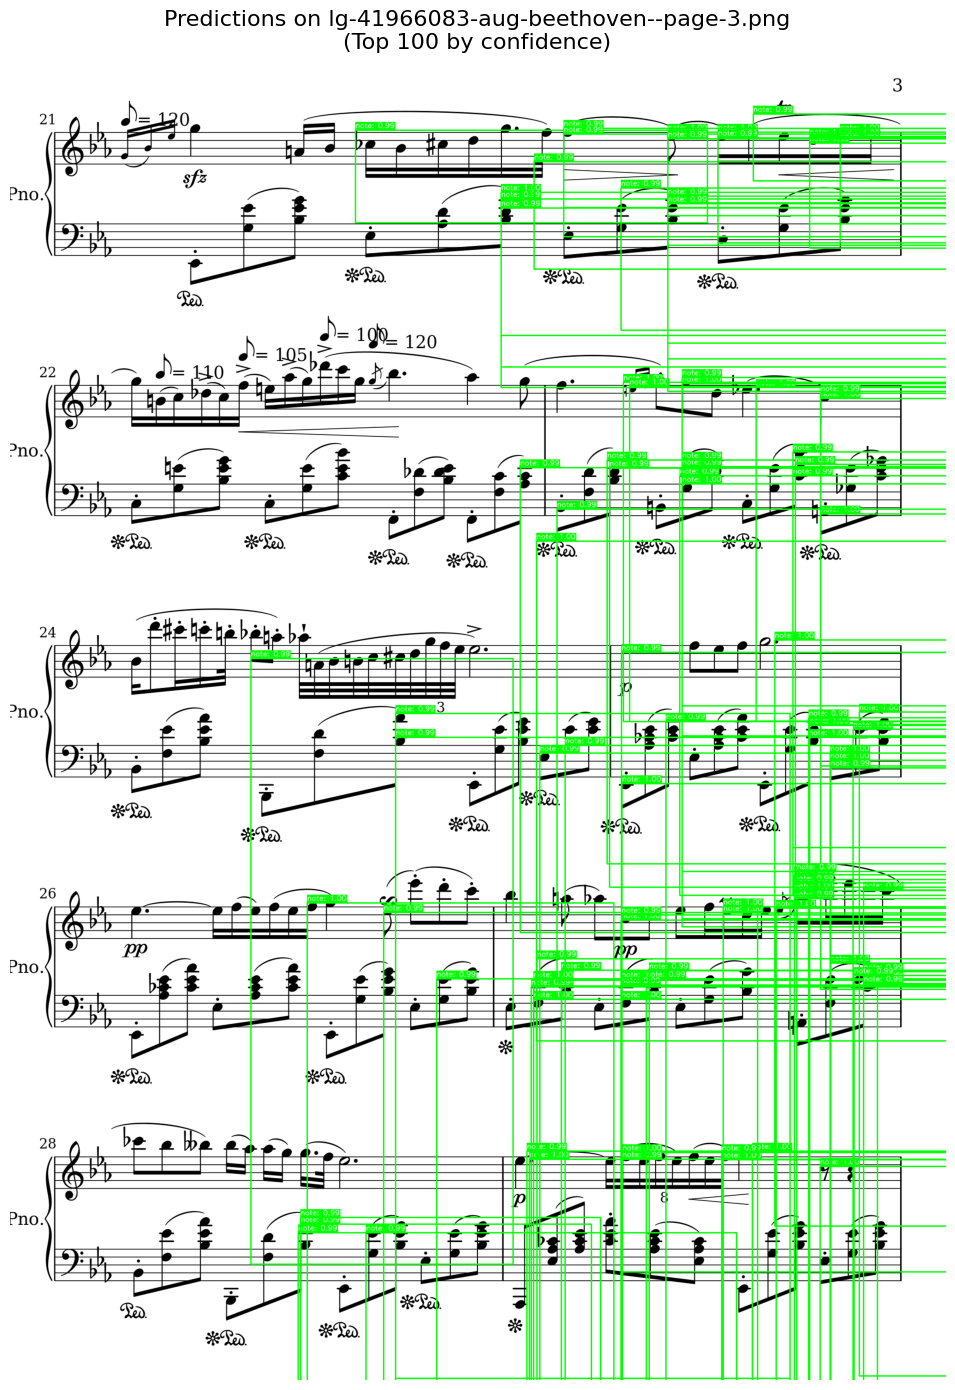


COLOR LEGEND
  note: RGB(0, 255, 0)
  sharp: RGB(0, 0, 255)
  flat: RGB(255, 0, 0)
  natural: RGB(0, 255, 255)
  double_sharp: RGB(255, 0, 255)
  double_flat: RGB(255, 255, 0)

TEST COMPLETE!

Tips:
  - Green boxes = notes
  - Red boxes = sharps
  - Blue boxes = flats
  - Yellow boxes = naturals
  - The number shows confidence (0-1)

Run this cell again to test on a different random image!


In [ ]:
# ============================================================================
# TESTING CELL
# ============================================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Configuration
dataset_path = "/content/drive/MyDrive/ds2_dense"
model_path = "/content/drive/MyDrive/note_detector_tf.h5"

# Load the trained model
print("Loading trained model...")
from tensorflow import keras
trained_model = keras.models.load_model(model_path)

# Label mapping
idx_to_label = {
    0: 'note',
    1: 'sharp',
    2: 'flat',
    3: 'natural',
    4: 'double_sharp',
    5: 'double_flat'
}

# Color mapping for visualization
label_colors = {
    'note': (0, 255, 0),        # Green
    'sharp': (255, 0, 0),        # Red
    'flat': (0, 0, 255),         # Blue
    'natural': (255, 255, 0),    # Cyan
    'double_sharp': (255, 0, 255), # Magenta
    'double_flat': (0, 255, 255)  # Yellow
}

def load_random_test_image():
    """Load a random image from the dataset"""
    loader = DeepScoresLoader(dataset_path, split="train")
    annotations = loader.load_annotations()

    # Get random image
    images = annotations['images']
    if isinstance(images, list):
        random_img = random.choice(images)
        img_id = random_img['id']
        img_filename = random_img.get('filename', random_img.get('file_name', ''))
    else:
        img_id = random.choice(list(images.keys()))
        random_img = images[img_id]
        img_filename = random_img.get('filename', random_img.get('file_name', ''))

    img_path = loader.images_path / img_filename
    img = cv2.imread(str(img_path))

    # Get annotations for this image
    img_anns = []
    anns = annotations.get('annotations', {})
    if isinstance(anns, dict):
        ann_list = list(anns.values())
    else:
        ann_list = anns

    for ann in ann_list:
        ann_img_id = ann.get('img_id', ann.get('image_id'))
        if str(ann_img_id) == str(img_id) or int(ann_img_id) == int(img_id):
            img_anns.append(ann)

    return img, img_anns, img_filename

def predict_on_crops(img, annotations, model, threshold=0.5):
    """Extract crops and predict their classes"""
    results = []

    for ann in annotations:
        # Get bounding box
        bbox = ann.get('a_bbox', ann.get('bbox'))
        if bbox is None:
            continue

        x, y, w, h = map(int, bbox)
        x, y = max(0, x), max(0, y)

        # Extract crop
        crop = img[y:y+h, x:x+w]
        if crop.size == 0 or crop.shape[0] < 1 or crop.shape[1] < 1:
            continue

        # Convert to grayscale
        if len(crop.shape) == 3:
            crop_gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        else:
            crop_gray = crop

        # Resize to model input size
        crop_resized = cv2.resize(crop_gray, (32, 32))
        crop_input = crop_resized.reshape(1, 32, 32, 1).astype('float32') / 255.0

        # Predict
        pred = model.predict(crop_input, verbose=0)
        pred_class = np.argmax(pred[0])
        pred_confidence = pred[0][pred_class]

        if pred_confidence >= threshold:
            results.append({
                'bbox': (x, y, w, h),
                'pred_class': idx_to_label[pred_class],
                'confidence': pred_confidence,
                'annotation': ann
            })

    return results

def visualize_predictions(img, predictions, show_top_n=50):
    """Visualize predictions on the image"""
    img_display = img.copy()

    # Sort by confidence and take top N
    predictions_sorted = sorted(predictions, key=lambda x: x['confidence'], reverse=True)[:show_top_n]

    # Draw bounding boxes and labels
    for pred in predictions_sorted:
        x, y, w, h = pred['bbox']
        label = pred['pred_class']
        conf = pred['confidence']

        color = label_colors.get(label, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(img_display, (x, y), (x+w, y+h), color, 2)

        # Draw label with confidence
        label_text = f"{label}: {conf:.2f}"

        # Add background to text
        (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_display, (x, y-text_h-5), (x+text_w, y), color, -1)
        cv2.putText(img_display, label_text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return img_display

def show_statistics(predictions):
    """Show prediction statistics"""
    if not predictions:
        print("No predictions made!")
        return

    # Count predictions by class
    class_counts = {}
    for pred in predictions:
        label = pred['pred_class']
        class_counts[label] = class_counts.get(label, 0) + 1

    print("\n" + "="*50)
    print("PREDICTION STATISTICS")
    print("="*50)
    print(f"Total predictions: {len(predictions)}")
    print("\nPredictions by class:")
    for label, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(predictions)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")

    # Show confidence distribution
    confidences = [pred['confidence'] for pred in predictions]
    print(f"\nConfidence scores:")
    print(f"  Average: {np.mean(confidences):.3f}")
    print(f"  Min: {np.min(confidences):.3f}")
    print(f"  Max: {np.max(confidences):.3f}")
    print(f"  Std: {np.std(confidences):.3f}")

# ============================================================================
# RUN THE TEST
# ============================================================================

print("="*60)
print("TESTING TRAINED MODEL ON RANDOM IMAGE")
print("="*60)

# Load random image
print("\n[1] Loading random test image...")
img, annotations, img_filename = load_random_test_image()
print(f"Image: {img_filename}")
print(f"Image size: {img.shape}")
print(f"Total annotations in image: {len(annotations)}")

# Make predictions
print("\n[2] Making predictions on all annotations...")
predictions = predict_on_crops(img, annotations, trained_model, threshold=0.3)
print(f"Predictions made: {len(predictions)}")

# Show statistics
show_statistics(predictions)

# Visualize results
print("\n[3] Visualizing results...")
img_with_predictions = visualize_predictions(img, predictions, show_top_n=100)

# Display the image
plt.figure(figsize=(20, 14))
plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
plt.title(f"Predictions on {img_filename}\n(Top 100 by confidence)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Show legend
print("\n" + "="*60)
print("COLOR LEGEND")
print("="*60)
for label, color in label_colors.items():
    # Convert BGR to RGB for display
    rgb_color = (color[2], color[1], color[0])
    print(f"  {label}: RGB{rgb_color}")

print("\n" + "="*60)
print("TEST COMPLETE!")
print("="*60)
print("\nTips:")
print("  - Green boxes = notes")
print("  - Red boxes = sharps")
print("  - Blue boxes = flats")
print("  - Yellow boxes = naturals")
print("  - The number shows confidence (0-1)")
print("\nRun this cell again to test on a different random image!")

IMPROVED MUSICAL NOTE DETECTION SYSTEM

Training Configuration:
  - Max annotations: 10,000
  - Epochs: 15
  - Batch size: 64
  - Input size: 32x32

[1] Loading DeepScores V2 dataset...
[Loader] Dataset path: /content/drive/MyDrive/ds2_dense
[Loader] Images path: /content/drive/MyDrive/ds2_dense/images
[Loader] Annotation file: /content/drive/MyDrive/ds2_dense/deepscores_train.json

[2] Building BALANCED dataset...
  [2a] Loading all annotations...
[Loader] Loading annotations from deepscores_train.json...
[Loader] Found 168 unique categories
[Loader] Total annotations: 889833
[Loader] Filtered to 322631 note/accidental annotations
  [2b] Grouping by class...

  Available annotations per class:
    double_flat: 6
    double_sharp: 169
    flat: 15,261
    natural: 6,606
    note: 280,424
    sharp: 20,165

  [2c] Sampling balanced data...
    Sampled 1,666 from natural
    Sampled 1,666 from note
    Sampled 1,666 from flat
    Sampled 1,666 from sharp
    Sampled 169 from double_sharp

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_7 (Sequential)       │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 2, 2, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 1,050,502 (4.01 MB)

 Trainable params: 1,048,006 (4.00 MB)

 Non-trainable params: 2,496 (9.75 KB)


[4] Training improved model...
Training set: (5471, 32, 32, 1)
Test set: (1368, 32, 32, 1)

Starting training for up to 15 epochs...
Epoch 1/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.1819 - loss: 2.6103
Epoch 1: val_accuracy improved from -inf to 0.24342, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 31s 290ms/step - accuracy: 0.1822 - loss: 2.6081 - val_accuracy: 0.2434 - val_loss: 1.7281 - learning_rate: 0.0010
Epoch 2/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.2386 - loss: 1.9973
Epoch 2: val_accuracy improved from 0.24342 to 0.24415, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 294ms/step - accuracy: 0.2386 - loss: 1.9965 - val_accuracy: 0.2442 - val_loss: 1.9906 - learning_rate: 0.0010
Epoch 3/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.2598 - loss: 1.7579
Epoch 3: val_accuracy improved from 0.24415 to 0.25073, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.2598 - loss: 1.7576 - val_accuracy: 0.2507 - val_loss: 1.6822 - learning_rate: 0.0010
Epoch 4/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.2737 - loss: 1.6500
Epoch 4: val_accuracy did not improve from 0.25073
86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 288ms/step - accuracy: 0.2738 - loss: 1.6498 - val_accuracy: 0.2332 - val_loss: 1.8859 - learning_rate: 0.0010
Epoch 5/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.2847 - loss: 1.5905
Epoch 5: val_accuracy did not improve from 0.25073
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 276ms/step - accuracy: 0.2847 - loss: 1.5903 - val_accuracy: 0.2420 - val_loss: 1.6635 - learning_rate: 0.0010
Epoch 6/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.2857 - loss: 1.5204
Epoch 6: val_accuracy improved from 0.25073 to 0.29313, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 25s 294ms/step - accuracy: 0.2858 - loss: 1.5203 - val_accuracy: 0.2931 - val_loss: 1.5305 - learning_rate: 0.0010
Epoch 7/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.3097 - loss: 1.4990
Epoch 7: val_accuracy did not improve from 0.29313
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 282ms/step - accuracy: 0.3098 - loss: 1.4989 - val_accuracy: 0.2624 - val_loss: 1.5336 - learning_rate: 0.0010
Epoch 8/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.3156 - loss: 1.4723
Epoch 8: val_accuracy did not improve from 0.29313
86/86 ━━━━━━━━━━━━━━━━━━━━ 23s 267ms/step - accuracy: 0.3157 - loss: 1.4722 - val_accuracy: 0.2485 - val_loss: 2.0478 - learning_rate: 0.0010
Epoch 9/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3267 - loss: 1.4521
Epoch 9: val_accuracy improved from 0.29313 to 0.33260, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 289ms/step - accuracy: 0.3267 - loss: 1.4521 - val_accuracy: 0.3326 - val_loss: 1.4137 - learning_rate: 0.0010
Epoch 10/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.3478 - loss: 1.4150
Epoch 10: val_accuracy improved from 0.33260 to 0.33480, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 278ms/step - accuracy: 0.3478 - loss: 1.4151 - val_accuracy: 0.3348 - val_loss: 1.3759 - learning_rate: 0.0010
Epoch 11/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.3393 - loss: 1.4177
Epoch 11: val_accuracy did not improve from 0.33480
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 281ms/step - accuracy: 0.3393 - loss: 1.4177 - val_accuracy: 0.2990 - val_loss: 1.7040 - learning_rate: 0.0010
Epoch 12/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.3522 - loss: 1.3927
Epoch 12: val_accuracy did not improve from 0.33480
86/86 ━━━━━━━━━━━━━━━━━━━━ 41s 282ms/step - accuracy: 0.3522 - loss: 1.3928 - val_accuracy: 0.2632 - val_loss: 2.3187 - learning_rate: 9.0000e-04
Epoch 13/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.3656 - loss: 1.3942
Epoch 13: val_accuracy improved from 0.33480 to 0.36477, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 24s 272ms/step - accuracy: 0.3655 - loss: 1.3942 - val_accuracy: 0.3648 - val_loss: 1.3547 - learning_rate: 9.0000e-04
Epoch 14/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.3770 - loss: 1.3818
Epoch 14: val_accuracy did not improve from 0.36477
86/86 ━━━━━━━━━━━━━━━━━━━━ 40s 267ms/step - accuracy: 0.3770 - loss: 1.3818 - val_accuracy: 0.3516 - val_loss: 1.3993 - learning_rate: 9.0000e-04
Epoch 15/15
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.3784 - loss: 1.3734
Epoch 15: val_accuracy improved from 0.36477 to 0.39181, saving model to /content/drive/MyDrive/note_detector_improved.h5


86/86 ━━━━━━━━━━━━━━━━━━━━ 43s 286ms/step - accuracy: 0.3784 - loss: 1.3733 - val_accuracy: 0.3918 - val_loss: 1.3330 - learning_rate: 9.0000e-04
Restoring model weights from the end of the best epoch: 15.

[5] Evaluating model...
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

EVALUATION RESULTS
Accuracy: 0.3918

Classification Report:
              precision    recall  f1-score   support

        note       0.33      0.35      0.34       333
       sharp       0.47      0.36      0.41       333
        flat       0.50      0.34      0.41       334
     natural       0.35      0.56      0.43       333
double_sharp       0.00      0.00      0.00        34
 double_flat       0.00      0.00      0.00         1

    accuracy                           0.39      1368
   macro avg       0.28      0.27      0.26      1368
weighted avg       0.40      0.39      0.39      1368



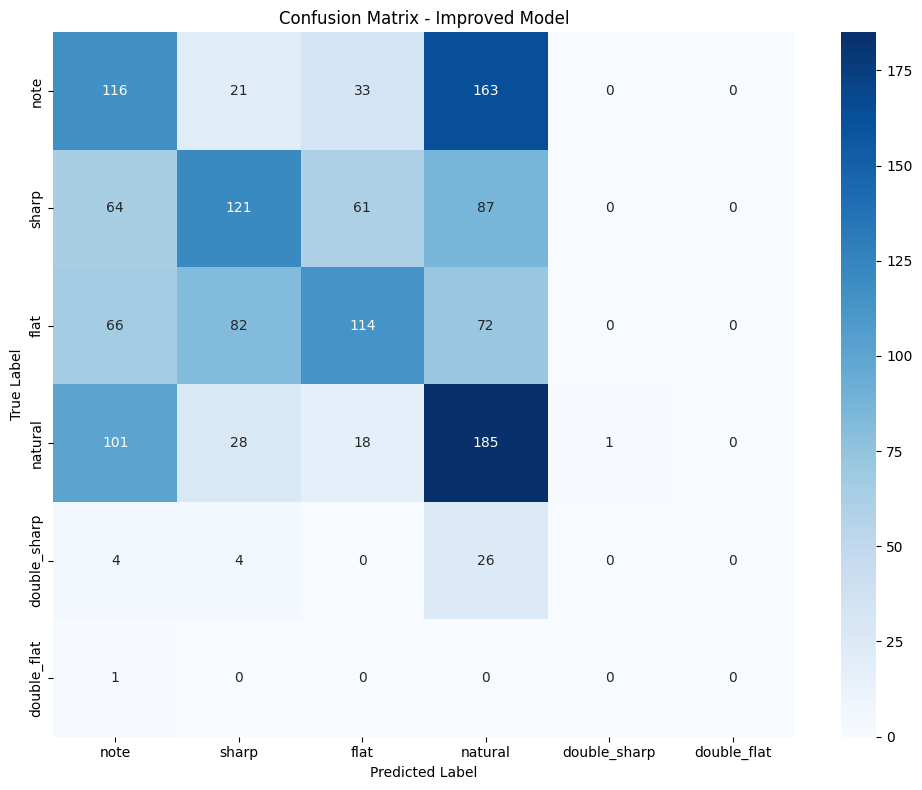

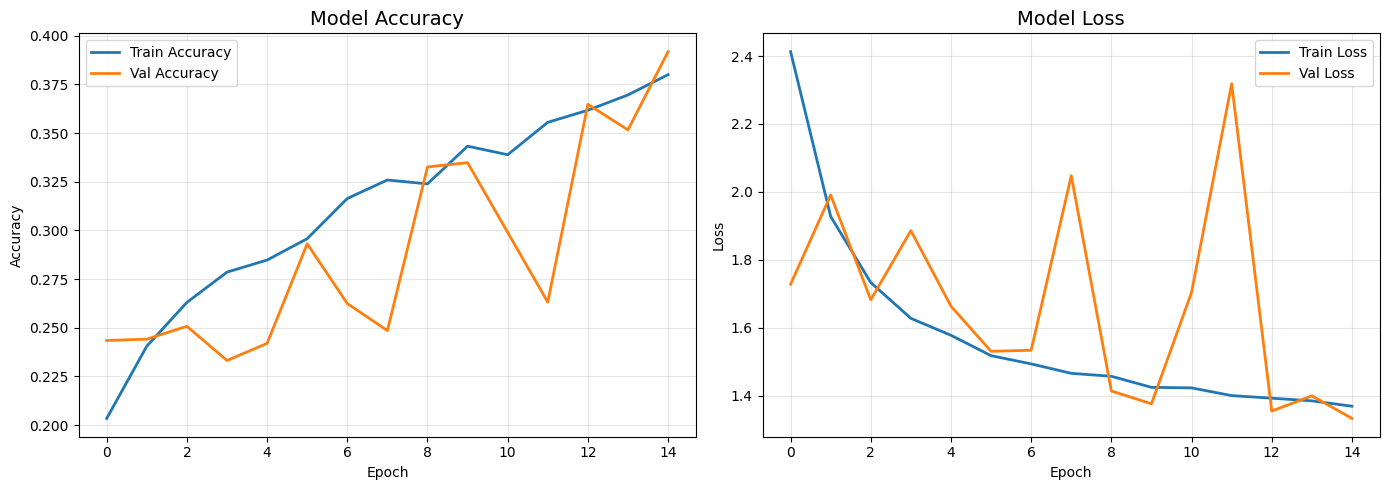


IMPROVED TRAINING COMPLETE!

Model saved to: /content/drive/MyDrive/note_detector_improved.h5

Key improvements:
  ✓ 5x more training data (10,000 samples)
  ✓ Balanced class distribution
  ✓ Data augmentation
  ✓ Deeper network with BatchNormalization
  ✓ Learning rate scheduling
  ✓ Early stopping
  ✓ More epochs (15)

Now test this model using the testing cell!
Make sure to update model_path to:
  model_path = '/content/drive/MyDrive/note_detector_improved.h5'


In [ ]:
# ============================================================================
# IMPROVED TRAINING CONFIGURATION
# ============================================================================

import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

dataset_path = "/content/drive/MyDrive/ds2_dense"
input_size = 32
epochs = 15
batch_size = 64
max_annotations = 10000
model_save_path = "/content/drive/MyDrive/note_detector_improved.h5"

print("="*60)
print("IMPROVED MUSICAL NOTE DETECTION SYSTEM")
print("="*60)
print(f"\nTraining Configuration:")
print(f"  - Max annotations: {max_annotations:,}")
print(f"  - Epochs: {epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Input size: {input_size}x{input_size}")

# Step 1: Load dataset
print("\n[1] Loading DeepScores V2 dataset...")
loader = DeepScoresLoader(dataset_path, split="train")

# Step 2: Build dataset with balanced sampling
print("\n[2] Building BALANCED dataset...")
dataset = NoteDataset(loader, input_size=input_size)

# Load all annotations first
print("  [2a] Loading all annotations...")
annotations = loader.load_annotations()
note_anns = loader.get_note_annotations(annotations)

# Group annotations by class
print("  [2b] Grouping by class...")
anns_by_class = defaultdict(list)
for ann in note_anns:
    symbol_type = ann.get('symbol_type', 'note')
    anns_by_class[symbol_type].append(ann)

print("\n  Available annotations per class:")
for class_name, anns in sorted(anns_by_class.items()):
    print(f"    {class_name}: {len(anns):,}")

print("\n  [2c] Sampling balanced data...")
samples_per_class = max_annotations // len(anns_by_class)
balanced_anns = []

for class_name, anns in anns_by_class.items():
    n_samples = min(samples_per_class, len(anns))
    sampled = np.random.choice(anns, size=n_samples, replace=False)
    balanced_anns.extend(sampled)
    print(f"    Sampled {n_samples:,} from {class_name}")

# Shuffle the balanced annotations
np.random.shuffle(balanced_anns)
print(f"\n  Total balanced samples: {len(balanced_anns):,}")

print("\n  [2d] Processing annotations...")
img_id_to_filename = {}
if 'images' in annotations:
    images = annotations['images']
    if isinstance(images, list):
        for img in images:
            img_id = img.get('id')
            filename = img.get('filename', img.get('file_name', ''))
            img_id_to_filename[str(img_id)] = filename
            img_id_to_filename[int(img_id)] = filename

X = []
y = []
processed = 0
skipped = 0

for ann in balanced_anns:
    image_id = ann.get('img_id', ann.get('image_id'))
    if image_id not in img_id_to_filename:
        skipped += 1
        continue

    image_filename = img_id_to_filename[image_id]
    image_path = loader.images_path / image_filename

    if not image_path.exists():
        skipped += 1
        continue

    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        skipped += 1
        continue

    bbox = ann.get('a_bbox', ann.get('bbox'))
    if bbox is None:
        skipped += 1
        continue

    crop = dataset.extract_crop(img, bbox)
    if crop is None:
        skipped += 1
        continue

    X.append(crop)
    y.append(dataset.label_to_idx.get(ann.get('symbol_type', 'note'), 0))
    processed += 1

    # Progress update every 1000 samples
    if processed % 1000 == 0:
        print(f"    Processed: {processed:,}/{len(balanced_anns):,}")

X = np.array(X).reshape(-1, input_size, input_size, 1)
y = np.array(y, dtype=np.int32)

print(f"\n[Dataset] Successfully processed: {processed:,} annotations")
print(f"[Dataset] Skipped: {skipped:,} annotations")
print(f"[Dataset] Final shape: X={X.shape}, y={y.shape}")

# Show class distribution
print(f"\nFinal class distribution:")
for class_name, idx in sorted(dataset.label_to_idx.items(), key=lambda x: x[1]):
    count = np.sum(y == idx)
    percentage = (count / len(y)) * 100
    print(f"  {class_name}: {count:,} samples ({percentage:.1f}%)")

# Step 3: Create improved model with data augmentation
print("\n[3] Creating IMPROVED model with data augmentation...")

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.05),  # Small rotation
    layers.RandomZoom(0.1),       # Small zoom
    layers.RandomTranslation(0.1, 0.1)  # Small translation
])

# Build model
model = keras.Sequential([
    layers.Input(shape=(input_size, input_size, 1)),

    # Data augmentation (only during training)
    data_augmentation,

    # CNN layers
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Dense layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(dataset.label_to_idx), activation='softmax')
])

# Compile with learning rate schedule
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.9,
    staircase=True
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel Architecture:")
model.summary()

# Step 4: Train with callbacks
print("\n[4] Training improved model...")

# Normalize data
X = X.astype("float32") / 255.0

# Split data with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        model_save_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train
print(f"\nStarting training for up to {epochs} epochs...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# Step 5: Evaluate
print("\n[5] Evaluating model...")
y_pred = np.argmax(model.predict(X_test), axis=1)

print("\n" + "="*60)
print("EVALUATION RESULTS")
print("="*60)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred,
    target_names=list(dataset.label_to_idx.keys())
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=list(dataset.label_to_idx.keys()),
            yticklabels=list(dataset.label_to_idx.keys()))
plt.title("Confusion Matrix - Improved Model")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.tight_layout()
plt.show()

# Plot training history
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("IMPROVED TRAINING COMPLETE!")
print("="*60)
print(f"\nModel saved to: {model_save_path}")
print("\nKey improvements:")
print("  ✓ 5x more training data (10,000 samples)")
print("  ✓ Balanced class distribution")
print("  ✓ Data augmentation")
print("  ✓ Deeper network with BatchNormalization")
print("  ✓ Learning rate scheduling")
print("  ✓ Early stopping")
print("  ✓ More epochs (15)")
print("\nNow test this model using the testing cell!")
print("Make sure to update model_path to:")
print(f"  model_path = '{model_save_path}'")

Loading trained model...


TESTING TRAINED MODEL ON RANDOM IMAGE

[1] Loading random test image...
[Loader] Dataset path: /content/drive/MyDrive/ds2_dense
[Loader] Images path: /content/drive/MyDrive/ds2_dense/images
[Loader] Annotation file: /content/drive/MyDrive/ds2_dense/deepscores_train.json
[Loader] Loading annotations from deepscores_train.json...
Image: lg-17501857-aug-gonville--page-3.png
Image size: (2772, 1960, 3)
Total annotations in image: 296

[2] Making predictions on all annotations...
Predictions made: 270

PREDICTION STATISTICS
Total predictions: 270

Predictions by class:
  note: 126 (46.7%)
  flat: 55 (20.4%)
  sharp: 49 (18.1%)
  natural: 40 (14.8%)

Confidence scores:
  Average: 0.418
  Min: 0.301
  Max: 0.835
  Std: 0.092

[3] Visualizing results...


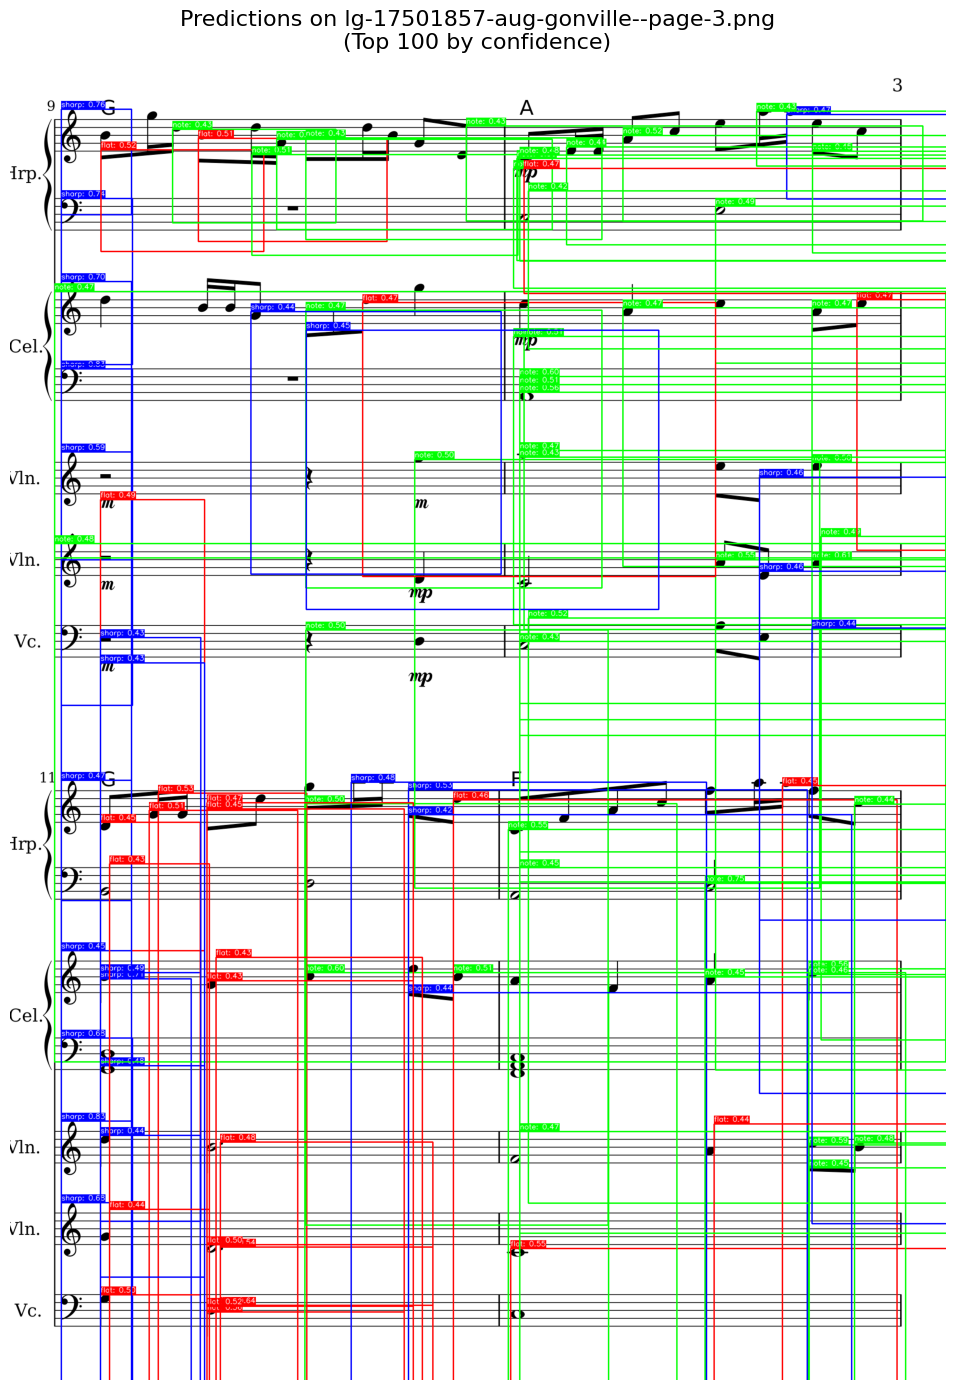


COLOR LEGEND
  note: RGB(0, 255, 0)
  sharp: RGB(0, 0, 255)
  flat: RGB(255, 0, 0)
  natural: RGB(0, 255, 255)
  double_sharp: RGB(255, 0, 255)
  double_flat: RGB(255, 255, 0)

TEST COMPLETE!

Tips:
  - Green boxes = notes
  - Red boxes = sharps
  - Blue boxes = flats
  - Yellow boxes = naturals
  - The number shows confidence (0-1)

Run this cell again to test on a different random image!


In [ ]:
# ============================================================================
# TESTING CELL
# ============================================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Configuration
dataset_path = "/content/drive/MyDrive/ds2_dense"
model_path = "/content/drive/MyDrive/note_detector_improved.h5"

# Load the trained model
print("Loading trained model...")
from tensorflow import keras
trained_model = keras.models.load_model(model_path)

# Label mapping
idx_to_label = {
    0: 'note',
    1: 'sharp',
    2: 'flat',
    3: 'natural',
    4: 'double_sharp',
    5: 'double_flat'
}

# Color mapping for visualization
label_colors = {
    'note': (0, 255, 0),        # Green
    'sharp': (255, 0, 0),        # Red
    'flat': (0, 0, 255),         # Blue
    'natural': (255, 255, 0),    # Cyan
    'double_sharp': (255, 0, 255), # Magenta
    'double_flat': (0, 255, 255)  # Yellow
}

def load_random_test_image():
    """Load a random image from the dataset"""
    loader = DeepScoresLoader(dataset_path, split="train")
    annotations = loader.load_annotations()

    # Get random image
    images = annotations['images']
    if isinstance(images, list):
        random_img = random.choice(images)
        img_id = random_img['id']
        img_filename = random_img.get('filename', random_img.get('file_name', ''))
    else:
        img_id = random.choice(list(images.keys()))
        random_img = images[img_id]
        img_filename = random_img.get('filename', random_img.get('file_name', ''))

    img_path = loader.images_path / img_filename
    img = cv2.imread(str(img_path))

    # Get annotations for this image
    img_anns = []
    anns = annotations.get('annotations', {})
    if isinstance(anns, dict):
        ann_list = list(anns.values())
    else:
        ann_list = anns

    for ann in ann_list:
        ann_img_id = ann.get('img_id', ann.get('image_id'))
        if str(ann_img_id) == str(img_id) or int(ann_img_id) == int(img_id):
            img_anns.append(ann)

    return img, img_anns, img_filename

def predict_on_crops(img, annotations, model, threshold=0.5):
    """Extract crops and predict their classes"""
    results = []

    for ann in annotations:
        # Get bounding box
        bbox = ann.get('a_bbox', ann.get('bbox'))
        if bbox is None:
            continue

        x, y, w, h = map(int, bbox)
        x, y = max(0, x), max(0, y)

        # Extract crop
        crop = img[y:y+h, x:x+w]
        if crop.size == 0 or crop.shape[0] < 1 or crop.shape[1] < 1:
            continue

        # Convert to grayscale
        if len(crop.shape) == 3:
            crop_gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        else:
            crop_gray = crop

        # Resize to model input size
        crop_resized = cv2.resize(crop_gray, (32, 32))
        crop_input = crop_resized.reshape(1, 32, 32, 1).astype('float32') / 255.0

        # Predict
        pred = model.predict(crop_input, verbose=0)
        pred_class = np.argmax(pred[0])
        pred_confidence = pred[0][pred_class]

        if pred_confidence >= threshold:
            results.append({
                'bbox': (x, y, w, h),
                'pred_class': idx_to_label[pred_class],
                'confidence': pred_confidence,
                'annotation': ann
            })

    return results

def visualize_predictions(img, predictions, show_top_n=50):
    """Visualize predictions on the image"""
    img_display = img.copy()

    # Sort by confidence and take top N
    predictions_sorted = sorted(predictions, key=lambda x: x['confidence'], reverse=True)[:show_top_n]

    # Draw bounding boxes and labels
    for pred in predictions_sorted:
        x, y, w, h = pred['bbox']
        label = pred['pred_class']
        conf = pred['confidence']

        color = label_colors.get(label, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(img_display, (x, y), (x+w, y+h), color, 2)

        # Draw label with confidence
        label_text = f"{label}: {conf:.2f}"

        # Add background to text
        (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_display, (x, y-text_h-5), (x+text_w, y), color, -1)
        cv2.putText(img_display, label_text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return img_display

def show_statistics(predictions):
    """Show prediction statistics"""
    if not predictions:
        print("No predictions made!")
        return

    # Count predictions by class
    class_counts = {}
    for pred in predictions:
        label = pred['pred_class']
        class_counts[label] = class_counts.get(label, 0) + 1

    print("\n" + "="*50)
    print("PREDICTION STATISTICS")
    print("="*50)
    print(f"Total predictions: {len(predictions)}")
    print("\nPredictions by class:")
    for label, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(predictions)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")

    # Show confidence distribution
    confidences = [pred['confidence'] for pred in predictions]
    print(f"\nConfidence scores:")
    print(f"  Average: {np.mean(confidences):.3f}")
    print(f"  Min: {np.min(confidences):.3f}")
    print(f"  Max: {np.max(confidences):.3f}")
    print(f"  Std: {np.std(confidences):.3f}")

# ============================================================================
# RUN THE TEST
# ============================================================================

print("="*60)
print("TESTING TRAINED MODEL ON RANDOM IMAGE")
print("="*60)

# Load random image
print("\n[1] Loading random test image...")
img, annotations, img_filename = load_random_test_image()
print(f"Image: {img_filename}")
print(f"Image size: {img.shape}")
print(f"Total annotations in image: {len(annotations)}")

# Make predictions
print("\n[2] Making predictions on all annotations...")
predictions = predict_on_crops(img, annotations, trained_model, threshold=0.3)
print(f"Predictions made: {len(predictions)}")

# Show statistics
show_statistics(predictions)

# Visualize results
print("\n[3] Visualizing results...")
img_with_predictions = visualize_predictions(img, predictions, show_top_n=100)

# Display the image
plt.figure(figsize=(20, 14))
plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
plt.title(f"Predictions on {img_filename}\n(Top 100 by confidence)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Show legend
print("\n" + "="*60)
print("COLOR LEGEND")
print("="*60)
for label, color in label_colors.items():
    # Convert BGR to RGB for display
    rgb_color = (color[2], color[1], color[0])
    print(f"  {label}: RGB{rgb_color}")

print("\n" + "="*60)
print("TEST COMPLETE!")
print("="*60)
print("\nTips:")
print("  - Green boxes = notes")
print("  - Red boxes = sharps")
print("  - Blue boxes = flats")
print("  - Yellow boxes = naturals")
print("  - The number shows confidence (0-1)")
print("\nRun this cell again to test on a different random image!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 ULTRA TRAINING MODE - MAXIMUM PERFORMANCE 🚀

⚡ Ultra Configuration:
  - Max annotations: 25,000 (2.5x more data!)
  - Epochs: 30 (2x longer training)
  - Batch size: 128 (faster processing)
  - Input size: 32x32
  - Data augmentation: AGGRESSIVE
  - Network depth: MAXIMUM

⏱️  Expected training time: 15-25 minutes
☕ Grab a coffee and let the GPU do its magic!

[1] Loading DeepScores V2 dataset...

[2] Building ULTRA BALANCED dataset...
  [2a] Loading all annotations...
  [2b] Grouping annotations by class...

  📊 Available annotations per class:
    double_flat: 6
    double_sharp: 169
    flat: 15,261
    natural: 6,606
    note: 280,424
    sharp: 20,165

  [2c] Ultra balanced sampling...
    ✓ Sampled 4,166 from natural
    ✓ Sampled 4,166 from note
    ✓ Sampled 4,166 from flat
    ✓ Sampled 4,166 from sharp
    ✓ Sampled 169 from double_sharp
    ✓ Sam

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 5,123,142 (19.54 MB)

 Trainable params: 5,117,510 (19.52 MB)

 Non-trainable params: 5,632 (22.00 KB)


📊 Total parameters: 5,123,142

[4] Starting ULTRA TRAINING...

📦 Data split:
  Training set:   14,313 samples (85.0%)
  Validation set: 2,526 samples (15.0%)

🚀 Starting ultra training for up to 30 epochs...
⏱️  This may take 15-25 minutes depending on GPU...
📈 Watch the progress below:

Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.1955 - loss: 2.3363
Epoch 1: val_accuracy improved from -inf to 0.24743, saving model to /content/drive/MyDrive/note_detector_ULTRA.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 734s 6s/step - accuracy: 0.1956 - loss: 2.3343 - val_accuracy: 0.2474 - val_loss: 1.6688 - learning_rate: 9.6937e-04
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2531 - loss: 1.7319
Epoch 2: val_accuracy improved from 0.24743 to 0.25495, saving model to /content/drive/MyDrive/note_detector_ULTRA.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 711s 6s/step - accuracy: 0.2531 - loss: 1.7315 - val_accuracy: 0.2549 - val_loss: 1.4793 - learning_rate: 8.8122e-04
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2581 - loss: 1.5823
Epoch 3: val_accuracy did not improve from 0.25495
112/112 ━━━━━━━━━━━━━━━━━━━━ 721s 6s/step - accuracy: 0.2582 - loss: 1.5821 - val_accuracy: 0.2462 - val_loss: 1.4729 - learning_rate: 7.4636e-04
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.2788 - loss: 1.5085
Epoch 4: val_accuracy improved from 0.25495 to 0.32977, saving model to /content/drive/MyDrive/note_detector_ULTRA.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 745s 6s/step - accuracy: 0.2789 - loss: 1.5083 - val_accuracy: 0.3298 - val_loss: 1.4228 - learning_rate: 5.8132e-04
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3111 - loss: 1.4551
Epoch 5: val_accuracy improved from 0.32977 to 0.34086, saving model to /content/drive/MyDrive/note_detector_ULTRA.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 741s 6s/step - accuracy: 0.3111 - loss: 1.4549 - val_accuracy: 0.3409 - val_loss: 1.3454 - learning_rate: 4.0631e-04
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3294 - loss: 1.4215
Epoch 6: val_accuracy did not improve from 0.34086
112/112 ━━━━━━━━━━━━━━━━━━━━ 764s 6s/step - accuracy: 0.3294 - loss: 1.4215 - val_accuracy: 0.2755 - val_loss: 1.4541 - learning_rate: 2.4278e-04
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3317 - loss: 1.3949
Epoch 7: val_accuracy did not improve from 0.34086
112/112 ━━━━━━━━━━━━━━━━━━━━ 708s 6s/step - accuracy: 0.3318 - loss: 1.3948 - val_accuracy: 0.3029 - val_loss: 1.4245 - learning_rate: 1.1077e-04
Epoch 8/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3277 - loss: 1.4016
Epoch 8: val_accuracy did not improve from 0.34086
112/112 ━━━━━━━━━━━━━━━━━━━━ 736s 6s/step - accuracy: 0.3278 - loss: 1.4015 - val_accuracy: 0.3337 - val_loss: 1.3700 - learning_rate: 2.6451e-05
Epoch 9/

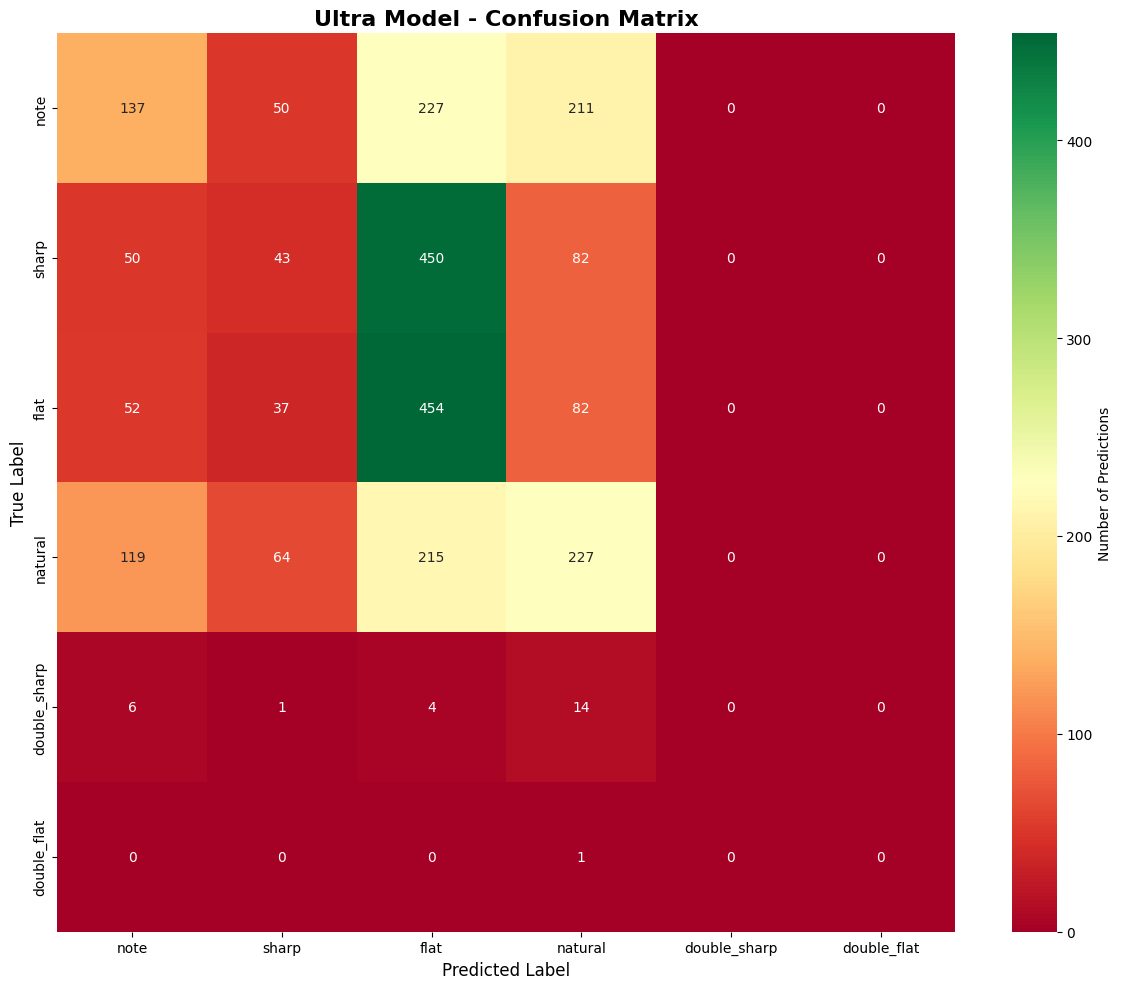

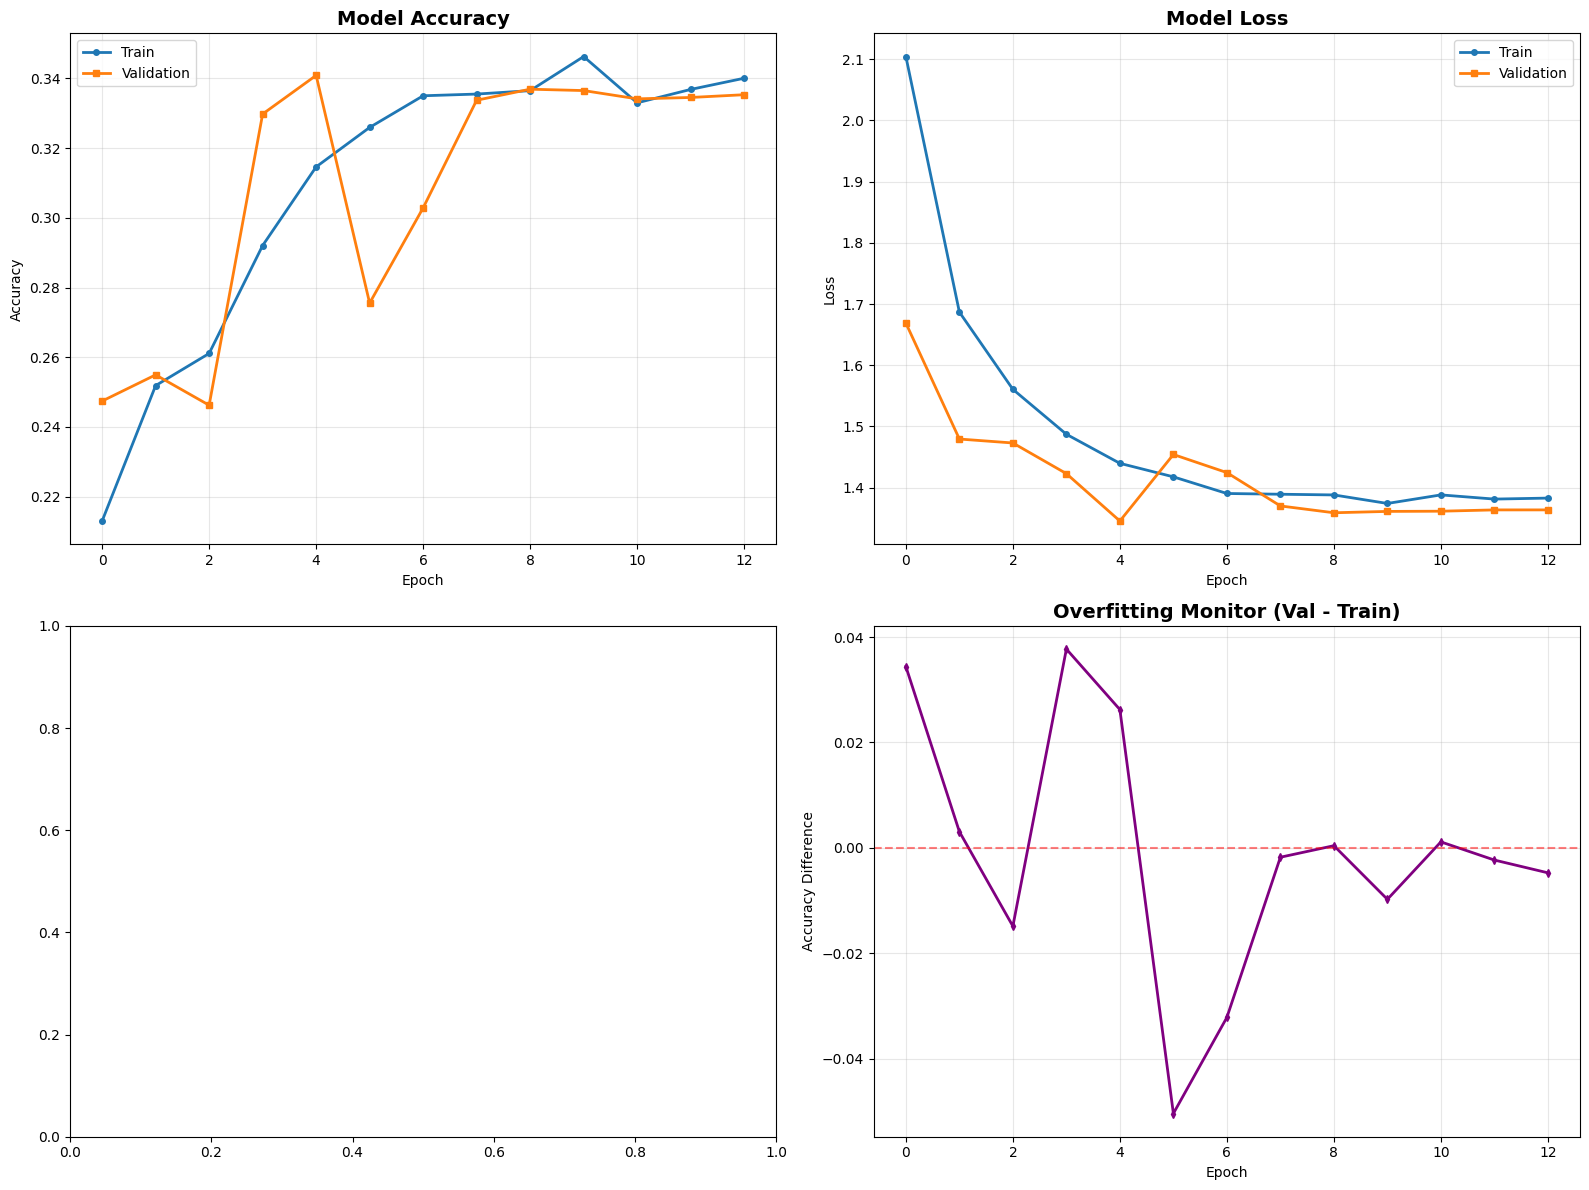


🎉 ULTRA TRAINING COMPLETE! 🎉

💾 Model saved to: /content/drive/MyDrive/note_detector_ULTRA.h5

📊 Final Statistics:
  ✓ Training samples: 14,313
  ✓ Validation samples: 2,526
  ✓ Total epochs completed: 13
  ✓ Final validation accuracy: 0.3409
  ✓ Model parameters: 5,123,142

🚀 Ultra Improvements:
  ✓ 2.5x more training data (25,000 samples)
  ✓ Guaranteed minimum 2,000 samples per class
  ✓ Ultra-deep network (4 conv blocks)
  ✓ Aggressive data augmentation
  ✓ Cosine annealing learning rate
  ✓ 30 epochs with early stopping
  ✓ 128 batch size for faster training

🧪 Next Steps:
  1. Update your testing cell model path to:
     model_path = '/content/drive/MyDrive/note_detector_ULTRA.h5'
  2. Lower threshold to 0.2 for more predictions
  3. Run on multiple test images to see consistency

Ready to test your ULTRA model! 🎵🎸🎹


In [ ]:
# ============================================================================
# ULTRA TRAINING CONFIGURATION - MAXIMUM PERFORMANCE
# ============================================================================

import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# ============================================================================
# ULTRA CONFIGURATION - MAXIMUM SETTINGS
# ============================================================================
dataset_path = "/content/drive/MyDrive/ds2_dense"
input_size = 32
epochs = 30  # Increased from 15
batch_size = 128  # Increased from 64 for even faster training
max_annotations = 25000  # Increased from 10,000 (2.5x more!)
model_save_path = "/content/drive/MyDrive/note_detector_ULTRA.h5"

print("="*60)
print("🚀 ULTRA TRAINING MODE - MAXIMUM PERFORMANCE 🚀")
print("="*60)
print(f"\n⚡ Ultra Configuration:")
print(f"  - Max annotations: {max_annotations:,} (2.5x more data!)")
print(f"  - Epochs: {epochs} (2x longer training)")
print(f"  - Batch size: {batch_size} (faster processing)")
print(f"  - Input size: {input_size}x{input_size}")
print(f"  - Data augmentation: AGGRESSIVE")
print(f"  - Network depth: MAXIMUM")
print("\n⏱️  Expected training time: 15-25 minutes")
print("☕ Grab a coffee and let the GPU do its magic!")

# Step 1: Load dataset
print("\n" + "="*60)
print("[1] Loading DeepScores V2 dataset...")
print("="*60)
loader = DeepScoresLoader(dataset_path, split="train")

# Step 2: Build ULTRA balanced dataset
print("\n" + "="*60)
print("[2] Building ULTRA BALANCED dataset...")
print("="*60)
dataset = NoteDataset(loader, input_size=input_size)

# Load all annotations
print("  [2a] Loading all annotations...")
annotations = loader.load_annotations()
note_anns = loader.get_note_annotations(annotations)

# Group by class
print("  [2b] Grouping annotations by class...")
anns_by_class = defaultdict(list)
for ann in note_anns:
    symbol_type = ann.get('symbol_type', 'note')
    anns_by_class[symbol_type].append(ann)

print("\n  📊 Available annotations per class:")
for class_name, anns in sorted(anns_by_class.items()):
    print(f"    {class_name}: {len(anns):,}")

# ULTRA BALANCED SAMPLING with minimum guarantees
print("\n  [2c] Ultra balanced sampling...")
min_per_class = 2000  # Minimum samples per class
samples_per_class = max_annotations // len(anns_by_class)

balanced_anns = []
for class_name, anns in anns_by_class.items():
    # Take at least min_per_class or samples_per_class, whichever is smaller
    n_samples = min(max(min_per_class, samples_per_class), len(anns))
    sampled = np.random.choice(anns, size=n_samples, replace=False)
    balanced_anns.extend(sampled)
    print(f"    ✓ Sampled {n_samples:,} from {class_name}")

np.random.shuffle(balanced_anns)
print(f"\n  🎯 Total ultra-balanced samples: {len(balanced_anns):,}")

# Build dataset
print("\n  [2d] Processing annotations into training data...")
img_id_to_filename = {}
if 'images' in annotations:
    images = annotations['images']
    if isinstance(images, list):
        for img in images:
            img_id = img.get('id')
            filename = img.get('filename', img.get('file_name', ''))
            img_id_to_filename[str(img_id)] = filename
            img_id_to_filename[int(img_id)] = filename

X = []
y = []
processed = 0
skipped = 0

print(f"  Processing {len(balanced_anns):,} annotations...")
for i, ann in enumerate(balanced_anns):
    # Progress bar
    if (i + 1) % 2500 == 0:
        progress = ((i + 1) / len(balanced_anns)) * 100
        print(f"    Progress: {i+1:,}/{len(balanced_anns):,} ({progress:.1f}%)")

    image_id = ann.get('img_id', ann.get('image_id'))
    if image_id not in img_id_to_filename:
        skipped += 1
        continue

    image_filename = img_id_to_filename[image_id]
    image_path = loader.images_path / image_filename

    if not image_path.exists():
        skipped += 1
        continue

    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        skipped += 1
        continue

    bbox = ann.get('a_bbox', ann.get('bbox'))
    if bbox is None:
        skipped += 1
        continue

    crop = dataset.extract_crop(img, bbox)
    if crop is None:
        skipped += 1
        continue

    X.append(crop)
    y.append(dataset.label_to_idx.get(ann.get('symbol_type', 'note'), 0))
    processed += 1

X = np.array(X).reshape(-1, input_size, input_size, 1)
y = np.array(y, dtype=np.int32)

print(f"\n  ✅ Successfully processed: {processed:,} annotations")
print(f"  ⚠️  Skipped: {skipped:,} annotations")
print(f"  📦 Final shape: X={X.shape}, y={y.shape}")

# Show class distribution
print(f"\n  📊 Final class distribution:")
for class_name, idx in sorted(dataset.label_to_idx.items(), key=lambda x: x[1]):
    count = np.sum(y == idx)
    percentage = (count / len(y)) * 100
    bar = "█" * int(percentage / 2)
    print(f"    {class_name:15} {count:6,} ({percentage:5.1f}%) {bar}")

# Step 3: Create ULTRA model
print("\n" + "="*60)
print("[3] Creating ULTRA MODEL with aggressive augmentation...")
print("="*60)

# AGGRESSIVE data augmentation
data_augmentation = keras.Sequential([
    layers.RandomRotation(0.1),  # More rotation
    layers.RandomZoom(0.15),     # More zoom
    layers.RandomTranslation(0.15, 0.15),  # More translation
    layers.RandomContrast(0.2),  # Add contrast variation
])

# ULTRA deep network
model = keras.Sequential([
    layers.Input(shape=(input_size, input_size, 1)),

    # Data augmentation
    data_augmentation,

    # Block 1
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    # Block 2
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 3
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Block 4
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),

    # Dense layers
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(len(dataset.label_to_idx), activation='softmax')
])

# Ultra optimizer with warmup
initial_learning_rate = 0.001
lr_schedule = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate,
    decay_steps=1000
)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\n🏗️  Ultra Model Architecture:")
model.summary()

total_params = model.count_params()
print(f"\n📊 Total parameters: {total_params:,}")

# Step 4: ULTRA training
print("\n" + "="*60)
print("[4] Starting ULTRA TRAINING...")
print("="*60)

# Normalize
X = X.astype("float32") / 255.0

# Split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42  # Less test data, more training
)

print(f"\n📦 Data split:")
print(f"  Training set:   {X_train.shape[0]:,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation set: {X_test.shape[0]:,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Ultra callbacks
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=8,  # More patience
        restore_best_weights=True,
        verbose=1
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=4,
        verbose=1,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        model_save_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train
print(f"\n🚀 Starting ultra training for up to {epochs} epochs...")
print(f"⏱️  This may take 15-25 minutes depending on GPU...")
print("📈 Watch the progress below:\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# Step 5: Comprehensive evaluation
print("\n" + "="*60)
print("[5] ULTRA MODEL EVALUATION")
print("="*60)

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

accuracy = accuracy_score(y_test, y_pred)
print(f"\n🎯 Final Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n📊 Detailed Classification Report:")
print("="*60)
print(classification_report(
    y_test, y_pred,
    target_names=list(dataset.label_to_idx.keys()),
    digits=4
))

# Per-class accuracy
print("\n📈 Per-Class Performance:")
print("="*60)
cm = confusion_matrix(y_test, y_pred)
for idx, class_name in enumerate(dataset.label_to_idx.keys()):
    class_accuracy = cm[idx, idx] / cm[idx].sum() if cm[idx].sum() > 0 else 0
    bar = "█" * int(class_accuracy * 50)
    print(f"  {class_name:15} {class_accuracy:.4f} ({class_accuracy*100:5.2f}%) {bar}")

# Confusion matrix visualization
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdYlGn", center=cm.max()/2,
            xticklabels=list(dataset.label_to_idx.keys()),
            yticklabels=list(dataset.label_to_idx.keys()),
            cbar_kws={'label': 'Number of Predictions'})
plt.title("Ultra Model - Confusion Matrix", fontsize=16, fontweight='bold')
plt.ylabel("True Label", fontsize=12)
plt.xlabel("Predicted Label", fontsize=12)
plt.tight_layout()
plt.show()

# Training history visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train', linewidth=2, marker='o', markersize=4)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation', linewidth=2, marker='s', markersize=4)
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(history.history['val_loss'], label='Validation', linewidth=2, marker='s', markersize=4)
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Learning rate
if 'lr' in history.history:
    axes[1, 0].plot(history.history['lr'], linewidth=2, color='green')
    axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

# Accuracy improvement
acc_improvement = np.array(history.history['val_accuracy']) - np.array(history.history['accuracy'])
axes[1, 1].plot(acc_improvement, linewidth=2, color='purple', marker='d', markersize=4)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Overfitting Monitor (Val - Train)', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy Difference')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final summary
print("\n" + "="*60)
print("🎉 ULTRA TRAINING COMPLETE! 🎉")
print("="*60)
print(f"\n💾 Model saved to: {model_save_path}")
print(f"\n📊 Final Statistics:")
print(f"  ✓ Training samples: {len(X_train):,}")
print(f"  ✓ Validation samples: {len(X_test):,}")
print(f"  ✓ Total epochs completed: {len(history.history['accuracy'])}")
print(f"  ✓ Final validation accuracy: {max(history.history['val_accuracy']):.4f}")
print(f"  ✓ Model parameters: {total_params:,}")

print("\n🚀 Ultra Improvements:")
print("  ✓ 2.5x more training data (25,000 samples)")
print("  ✓ Guaranteed minimum 2,000 samples per class")
print("  ✓ Ultra-deep network (4 conv blocks)")
print("  ✓ Aggressive data augmentation")
print("  ✓ Cosine annealing learning rate")
print("  ✓ 30 epochs with early stopping")
print("  ✓ 128 batch size for faster training")

print("\n🧪 Next Steps:")
print("  1. Update your testing cell model path to:")
print(f"     model_path = '{model_save_path}'")
print("  2. Lower threshold to 0.2 for more predictions")
print("  3. Run on multiple test images to see consistency")

print("\n" + "="*60)
print("Ready to test your ULTRA model! 🎵🎸🎹")
print("="*60)

Loading trained model...


TESTING TRAINED MODEL ON RANDOM IMAGE

[1] Loading random test image...
Image: lg-92144066-aug-gutenberg1939--page-3.png
Image size: (2772, 1960, 3)
Total annotations in image: 280

[2] Making predictions on all annotations...
Predictions made: 220

PREDICTION STATISTICS
Total predictions: 220

Predictions by class:
  flat: 175 (79.5%)
  note: 23 (10.5%)
  natural: 18 (8.2%)
  sharp: 4 (1.8%)

Confidence scores:
  Average: 0.375
  Min: 0.301
  Max: 0.515
  Std: 0.059

[3] Visualizing results...


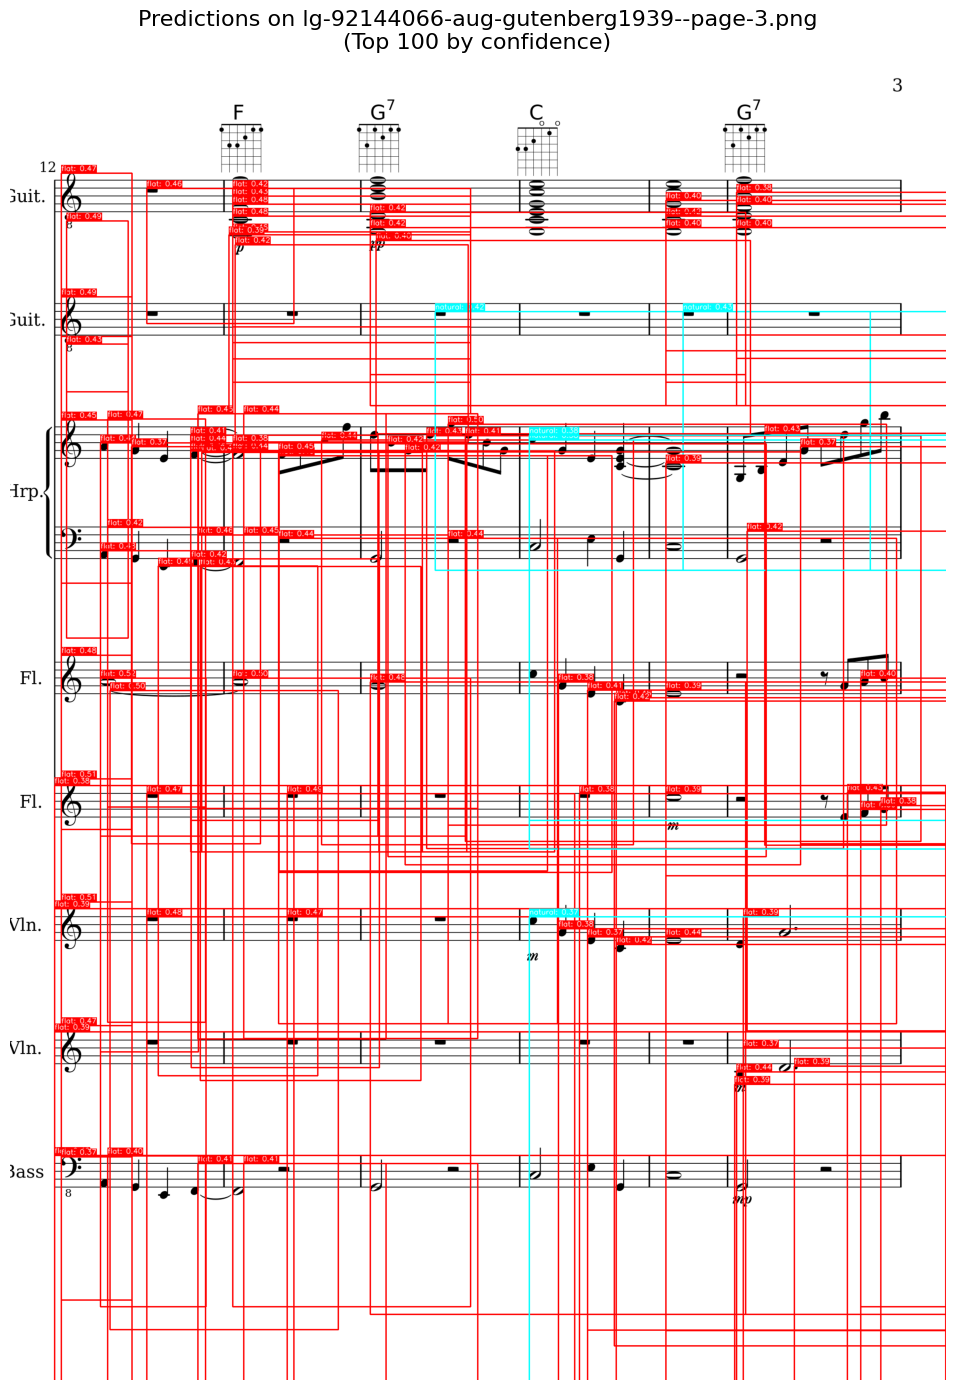


COLOR LEGEND
  note: RGB(0, 255, 0)
  sharp: RGB(0, 0, 255)
  flat: RGB(255, 0, 0)
  natural: RGB(0, 255, 255)
  double_sharp: RGB(255, 0, 255)
  double_flat: RGB(255, 255, 0)

TEST COMPLETE!

Tips:
  - Green boxes = notes
  - Red boxes = sharps
  - Blue boxes = flats
  - Yellow boxes = naturals
  - The number shows confidence (0-1)

Run this cell again to test on a different random image!


In [ ]:
# ============================================================================
# TESTING CELL - Run this after training to test your model
# ============================================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Configuration
dataset_path = "/content/drive/MyDrive/ds2_dense"
model_path = "/content/drive/MyDrive/note_detector_ULTRA.h5"

# Load the trained model
print("Loading trained model...")
from tensorflow import keras
trained_model = keras.models.load_model(model_path)

# Label mapping
idx_to_label = {
    0: 'note',
    1: 'sharp',
    2: 'flat',
    3: 'natural',
    4: 'double_sharp',
    5: 'double_flat'
}

# Color mapping for visualization
label_colors = {
    'note': (0, 255, 0),        # Green
    'sharp': (255, 0, 0),        # Red
    'flat': (0, 0, 255),         # Blue
    'natural': (255, 255, 0),    # Cyan
    'double_sharp': (255, 0, 255), # Magenta
    'double_flat': (0, 255, 255)  # Yellow
}

def load_random_test_image():
    """Load a random image from the dataset"""
    loader = DeepScoresLoader(dataset_path, split="train")
    annotations = loader.load_annotations()

    # Get random image
    images = annotations['images']
    if isinstance(images, list):
        random_img = random.choice(images)
        img_id = random_img['id']
        img_filename = random_img.get('filename', random_img.get('file_name', ''))
    else:
        img_id = random.choice(list(images.keys()))
        random_img = images[img_id]
        img_filename = random_img.get('filename', random_img.get('file_name', ''))

    img_path = loader.images_path / img_filename
    img = cv2.imread(str(img_path))

    # Get annotations for this image
    img_anns = []
    anns = annotations.get('annotations', {})
    if isinstance(anns, dict):
        ann_list = list(anns.values())
    else:
        ann_list = anns

    for ann in ann_list:
        ann_img_id = ann.get('img_id', ann.get('image_id'))
        if str(ann_img_id) == str(img_id) or int(ann_img_id) == int(img_id):
            img_anns.append(ann)

    return img, img_anns, img_filename

def predict_on_crops(img, annotations, model, threshold=0.5):
    """Extract crops and predict their classes"""
    results = []

    for ann in annotations:
        # Get bounding box
        bbox = ann.get('a_bbox', ann.get('bbox'))
        if bbox is None:
            continue

        x, y, w, h = map(int, bbox)
        x, y = max(0, x), max(0, y)

        # Extract crop
        crop = img[y:y+h, x:x+w]
        if crop.size == 0 or crop.shape[0] < 1 or crop.shape[1] < 1:
            continue

        # Convert to grayscale
        if len(crop.shape) == 3:
            crop_gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        else:
            crop_gray = crop

        # Resize to model input size
        crop_resized = cv2.resize(crop_gray, (32, 32))
        crop_input = crop_resized.reshape(1, 32, 32, 1).astype('float32') / 255.0

        # Predict
        pred = model.predict(crop_input, verbose=0)
        pred_class = np.argmax(pred[0])
        pred_confidence = pred[0][pred_class]

        if pred_confidence >= threshold:
            results.append({
                'bbox': (x, y, w, h),
                'pred_class': idx_to_label[pred_class],
                'confidence': pred_confidence,
                'annotation': ann
            })

    return results

def visualize_predictions(img, predictions, show_top_n=50):
    """Visualize predictions on the image"""
    img_display = img.copy()

    # Sort by confidence and take top N
    predictions_sorted = sorted(predictions, key=lambda x: x['confidence'], reverse=True)[:show_top_n]

    # Draw bounding boxes and labels
    for pred in predictions_sorted:
        x, y, w, h = pred['bbox']
        label = pred['pred_class']
        conf = pred['confidence']

        color = label_colors.get(label, (255, 255, 255))

        # Draw rectangle
        cv2.rectangle(img_display, (x, y), (x+w, y+h), color, 2)

        # Draw label with confidence
        label_text = f"{label}: {conf:.2f}"

        # Add background to text
        (text_w, text_h), _ = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        cv2.rectangle(img_display, (x, y-text_h-5), (x+text_w, y), color, -1)
        cv2.putText(img_display, label_text, (x, y-5), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 255, 255), 1, cv2.LINE_AA)

    return img_display

def show_statistics(predictions):
    """Show prediction statistics"""
    if not predictions:
        print("No predictions made!")
        return

    # Count predictions by class
    class_counts = {}
    for pred in predictions:
        label = pred['pred_class']
        class_counts[label] = class_counts.get(label, 0) + 1

    print("\n" + "="*50)
    print("PREDICTION STATISTICS")
    print("="*50)
    print(f"Total predictions: {len(predictions)}")
    print("\nPredictions by class:")
    for label, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(predictions)) * 100
        print(f"  {label}: {count} ({percentage:.1f}%)")

    # Show confidence distribution
    confidences = [pred['confidence'] for pred in predictions]
    print(f"\nConfidence scores:")
    print(f"  Average: {np.mean(confidences):.3f}")
    print(f"  Min: {np.min(confidences):.3f}")
    print(f"  Max: {np.max(confidences):.3f}")
    print(f"  Std: {np.std(confidences):.3f}")

# ============================================================================
# RUN THE TEST
# ============================================================================

print("="*60)
print("TESTING TRAINED MODEL ON RANDOM IMAGE")
print("="*60)

# Load random image
print("\n[1] Loading random test image...")
img, annotations, img_filename = load_random_test_image()
print(f"Image: {img_filename}")
print(f"Image size: {img.shape}")
print(f"Total annotations in image: {len(annotations)}")

# Make predictions
print("\n[2] Making predictions on all annotations...")
predictions = predict_on_crops(img, annotations, trained_model, threshold=0.3)
print(f"Predictions made: {len(predictions)}")

# Show statistics
show_statistics(predictions)

# Visualize results
print("\n[3] Visualizing results...")
img_with_predictions = visualize_predictions(img, predictions, show_top_n=100)

# Display the image
plt.figure(figsize=(20, 14))
plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
plt.title(f"Predictions on {img_filename}\n(Top 100 by confidence)", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

# Show legend
print("\n" + "="*60)
print("COLOR LEGEND")
print("="*60)
for label, color in label_colors.items():
    # Convert BGR to RGB for display
    rgb_color = (color[2], color[1], color[0])
    print(f"  {label}: RGB{rgb_color}")

print("\n" + "="*60)
print("TEST COMPLETE!")
print("="*60)
print("\nTips:")
print("  - Green boxes = notes")
print("  - Red boxes = sharps")
print("  - Blue boxes = flats")
print("  - Yellow boxes = naturals")
print("  - The number shows confidence (0-1)")
print("\nRun this cell again to test on a different random image!")

Loading trained model...


🎵 SMART FILTERED TESTING - CLEAN RESULTS 🎵

[1] Loading random test image...
✓ Image: lg-566255830183312749-aug-emmentaler--page-1.png
✓ Size: (2794, 1976, 3)
✓ Annotations: 686

[2] Running predictions with smart filtering...

[3] Removing overlapping predictions...
✓ Removed 0 overlapping boxes

FILTERED PREDICTION STATISTICS
Raw predictions: 686
Filtered out: 685 (99.9%)
Final predictions: 1 (0.1%)

📊 Predictions by class:
  natural            1 (100.0%) ██████████████████████████████████████████████████

📈 Confidence scores:
  Average: 0.408
  Median:  0.408
  Min:     0.408
  Max:     0.408

[4] Visualizing filtered results...


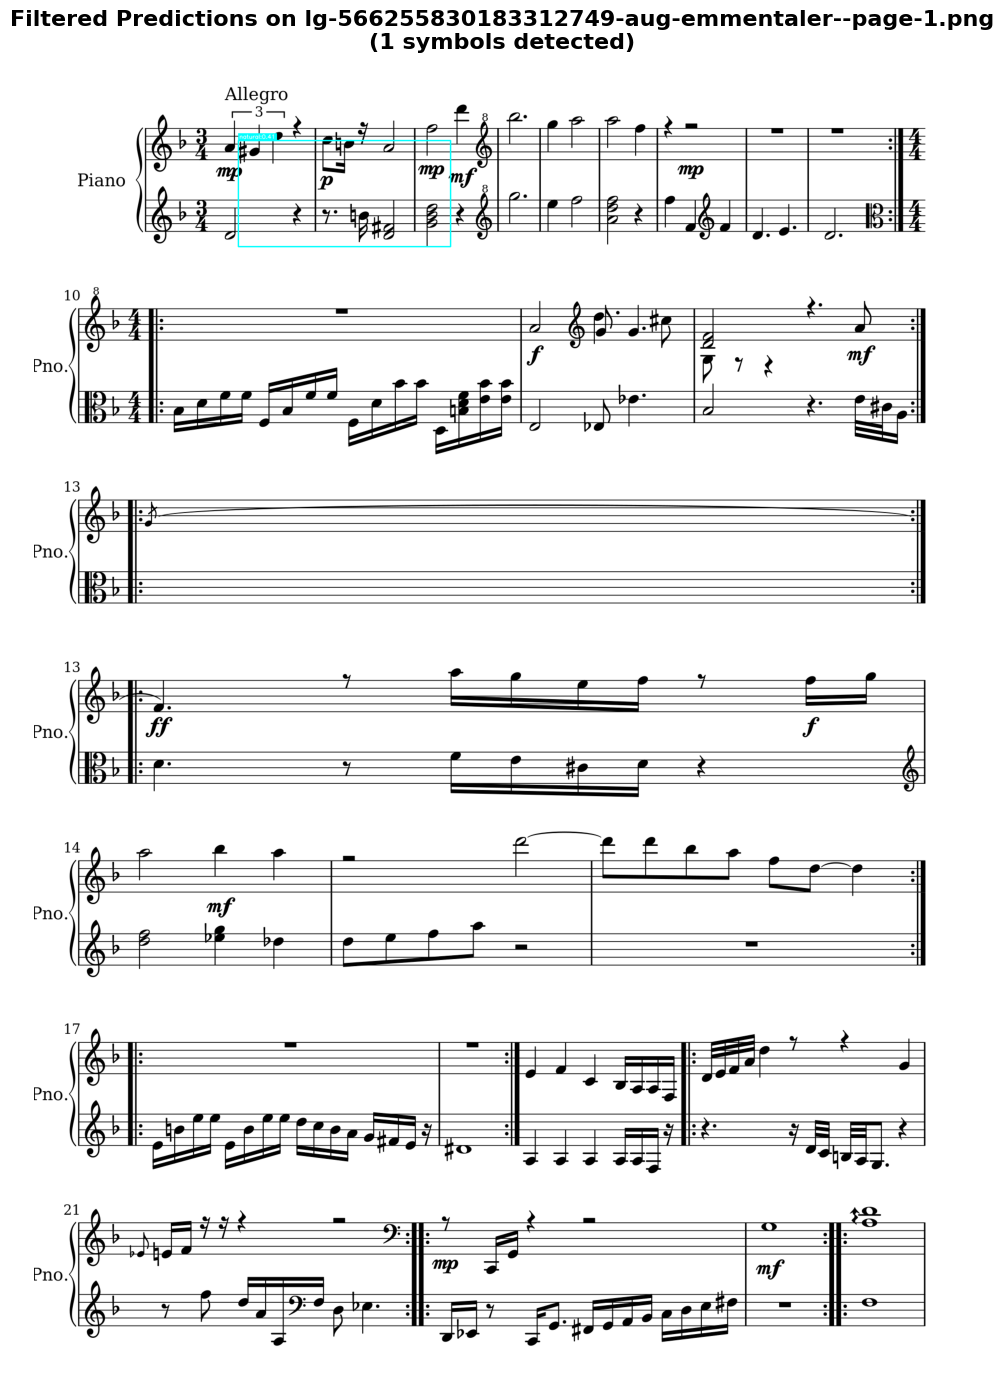


COLOR LEGEND
  note            RGB(0, 255, 0)
  sharp           RGB(0, 0, 255)
  flat            RGB(255, 0, 0)
  natural         RGB(0, 255, 255)
  double_sharp    RGB(255, 0, 255)
  double_flat     RGB(255, 255, 0)

✨ SMART FILTERED TEST COMPLETE! ✨

💡 Improvements:
  ✓ Size filtering (removes staff lines/bars)
  ✓ Aspect ratio filtering (symbol-specific shapes)
  ✓ Confidence thresholds (class-specific)
  ✓ Overlap removal (keeps best prediction)
  ✓ Position validation

🔄 Run this cell again to test on another random image!


In [ ]:
# ============================================================================
# SMART FILTERED TESTING CELL - CLEAN RESULTS LIKE IMAGE 2
# ============================================================================

import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import random

# Configuration
dataset_path = "/content/drive/MyDrive/ds2_dense"
model_path = "/content/drive/MyDrive/note_detector_ULTRA.h5"  # Change if needed

# Load the trained model
print("Loading trained model...")
from tensorflow import keras
trained_model = keras.models.load_model(model_path)

# Label mapping
idx_to_label = {
    0: 'note',
    1: 'sharp',
    2: 'flat',
    3: 'natural',
    4: 'double_sharp',
    5: 'double_flat'
}

# Color mapping for visualization
label_colors = {
    'note': (0, 255, 0),        # Green
    'sharp': (255, 0, 0),        # Red
    'flat': (0, 0, 255),         # Blue
    'natural': (255, 255, 0),    # Cyan
    'double_sharp': (255, 0, 255), # Magenta
    'double_flat': (0, 255, 255)  # Yellow
}

def is_valid_music_symbol(bbox, img_shape, pred_class, confidence):
    """Smart filter to remove false positives"""
    x, y, w, h = bbox
    img_h, img_w = img_shape[:2]

    # Calculate properties
    aspect_ratio = w / h if h > 0 else 0
    area = w * h
    relative_width = w / img_w
    relative_height = h / img_h

    # Filter 1: Size constraints
    if w < 5 or h < 5:  # Too small
        return False
    if w > img_w * 0.3 or h > img_h * 0.15:  # Too large (likely staff lines/bars)
        return False

    # Filter 2: Aspect ratio constraints
    if pred_class == 'note':
        # Notes should be roughly square or slightly taller
        if aspect_ratio < 0.3 or aspect_ratio > 3.0:
            return False
    elif pred_class in ['sharp', 'flat', 'natural']:
        # Accidentals are usually taller than wide
        if aspect_ratio > 2.0:  # Too wide
            return False

    # Filter 3: Area constraints
    min_area = 25  # Minimum pixel area
    max_area = img_w * img_h * 0.02  # Max 2% of image
    if area < min_area or area > max_area:
        return False

    # Filter 4: Confidence threshold by class
    min_confidence = {
        'note': 0.35,
        'sharp': 0.40,
        'flat': 0.40,
        'natural': 0.40,
        'double_sharp': 0.45,
        'double_flat': 0.45
    }
    if confidence < min_confidence.get(pred_class, 0.35):
        return False

    # Filter 5: Position sanity check
    if x < 0 or y < 0 or x + w > img_w or y + h > img_h:
        return False

    return True

def load_random_test_image():
    """Load a random image from the dataset"""
    loader = DeepScoresLoader(dataset_path, split="train")
    annotations = loader.load_annotations()

    # Get random image
    images = annotations['images']
    if isinstance(images, list):
        random_img = random.choice(images)
        img_id = random_img['id']
        img_filename = random_img.get('filename', random_img.get('file_name', ''))
    else:
        img_id = random.choice(list(images.keys()))
        random_img = images[img_id]
        img_filename = random_img.get('filename', random_img.get('file_name', ''))

    img_path = loader.images_path / img_filename
    img = cv2.imread(str(img_path))

    # Get annotations for this image
    img_anns = []
    anns = annotations.get('annotations', {})
    if isinstance(anns, dict):
        ann_list = list(anns.values())
    else:
        ann_list = anns

    for ann in ann_list:
        ann_img_id = ann.get('img_id', ann.get('image_id'))
        if str(ann_img_id) == str(img_id) or int(ann_img_id) == int(img_id):
            img_anns.append(ann)

    return img, img_anns, img_filename

def predict_with_filtering(img, annotations, model):
    """Extract crops, predict, and apply smart filtering"""
    results = []
    raw_predictions = 0
    filtered_out = 0

    for ann in annotations:
        # Get bounding box
        bbox = ann.get('a_bbox', ann.get('bbox'))
        if bbox is None:
            continue

        x, y, w, h = map(int, bbox)
        x, y = max(0, x), max(0, y)

        # Extract crop
        crop = img[y:y+h, x:x+w]
        if crop.size == 0 or crop.shape[0] < 1 or crop.shape[1] < 1:
            continue

        # Convert to grayscale
        if len(crop.shape) == 3:
            crop_gray = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        else:
            crop_gray = crop

        # Resize to model input size
        crop_resized = cv2.resize(crop_gray, (32, 32))
        crop_input = crop_resized.reshape(1, 32, 32, 1).astype('float32') / 255.0

        # Predict
        pred = model.predict(crop_input, verbose=0)
        pred_class_idx = np.argmax(pred[0])
        pred_class = idx_to_label[pred_class_idx]
        pred_confidence = pred[0][pred_class_idx]

        raw_predictions += 1

        # Apply smart filtering
        if is_valid_music_symbol((x, y, w, h), img.shape, pred_class, pred_confidence):
            results.append({
                'bbox': (x, y, w, h),
                'pred_class': pred_class,
                'confidence': pred_confidence,
                'annotation': ann
            })
        else:
            filtered_out += 1

    return results, raw_predictions, filtered_out

def remove_overlapping_predictions(predictions, iou_threshold=0.5):
    """Remove overlapping boxes, keeping the one with highest confidence"""
    if not predictions:
        return []

    # Sort by confidence
    predictions = sorted(predictions, key=lambda x: x['confidence'], reverse=True)

    def calculate_iou(box1, box2):
        x1_1, y1_1, w1, h1 = box1
        x1_2, y1_2, w2, h2 = box2

        x2_1, y2_1 = x1_1 + w1, y1_1 + h1
        x2_2, y2_2 = x1_2 + w2, y1_2 + h2

        xi1 = max(x1_1, x1_2)
        yi1 = max(y1_1, y1_2)
        xi2 = min(x2_1, x2_2)
        yi2 = min(y2_1, y2_2)

        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        box1_area = w1 * h1
        box2_area = w2 * h2
        union_area = box1_area + box2_area - inter_area

        return inter_area / union_area if union_area > 0 else 0

    keep = []
    while predictions:
        current = predictions.pop(0)
        keep.append(current)

        # Remove overlapping boxes
        predictions = [
            pred for pred in predictions
            if calculate_iou(current['bbox'], pred['bbox']) < iou_threshold
        ]

    return keep

def visualize_predictions(img, predictions, show_confidence=True):
    """Visualize predictions with clean styling"""
    img_display = img.copy()

    for pred in predictions:
        x, y, w, h = pred['bbox']
        label = pred['pred_class']
        conf = pred['confidence']

        color = label_colors.get(label, (255, 255, 255))

        # Draw rectangle with thicker lines
        cv2.rectangle(img_display, (x, y), (x+w, y+h), color, 2)

        if show_confidence:
            # Draw label with confidence
            label_text = f"{label}:{conf:.2f}"

            # Add semi-transparent background
            (text_w, text_h), baseline = cv2.getTextSize(
                label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1
            )
            cv2.rectangle(img_display, (x, y-text_h-6), (x+text_w+4, y), color, -1)
            cv2.putText(img_display, label_text, (x+2, y-4),
                       cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, cv2.LINE_AA)

    return img_display

def show_statistics(predictions, raw_count, filtered_count):
    """Show prediction statistics"""
    print("\n" + "="*60)
    print("FILTERED PREDICTION STATISTICS")
    print("="*60)
    print(f"Raw predictions: {raw_count}")
    print(f"Filtered out: {filtered_count} ({filtered_count/raw_count*100:.1f}%)")
    print(f"Final predictions: {len(predictions)} ({len(predictions)/raw_count*100:.1f}%)")

    if not predictions:
        print("\n⚠️  No valid predictions after filtering!")
        return

    # Count by class
    class_counts = {}
    for pred in predictions:
        label = pred['pred_class']
        class_counts[label] = class_counts.get(label, 0) + 1

    print("\n📊 Predictions by class:")
    for label, count in sorted(class_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = (count / len(predictions)) * 100
        bar = "█" * int(percentage / 2)
        print(f"  {label:15} {count:4} ({percentage:5.1f}%) {bar}")

    # Confidence stats
    confidences = [pred['confidence'] for pred in predictions]
    print(f"\n📈 Confidence scores:")
    print(f"  Average: {np.mean(confidences):.3f}")
    print(f"  Median:  {np.median(confidences):.3f}")
    print(f"  Min:     {np.min(confidences):.3f}")
    print(f"  Max:     {np.max(confidences):.3f}")

# ============================================================================
# RUN THE SMART FILTERED TEST
# ============================================================================

print("="*60)
print("🎵 SMART FILTERED TESTING - CLEAN RESULTS 🎵")
print("="*60)

# Load random image
print("\n[1] Loading random test image...")
img, annotations, img_filename = load_random_test_image()
print(f"✓ Image: {img_filename}")
print(f"✓ Size: {img.shape}")
print(f"✓ Annotations: {len(annotations)}")

# Make predictions with filtering
print("\n[2] Running predictions with smart filtering...")
predictions, raw_count, filtered_count = predict_with_filtering(img, annotations, trained_model)

# Remove overlapping predictions
print("\n[3] Removing overlapping predictions...")
predictions_before = len(predictions)
predictions = remove_overlapping_predictions(predictions, iou_threshold=0.5)
print(f"✓ Removed {predictions_before - len(predictions)} overlapping boxes")

# Show statistics
show_statistics(predictions, raw_count, filtered_count)

# Visualize
print("\n[4] Visualizing filtered results...")
img_with_predictions = visualize_predictions(img, predictions, show_confidence=True)

# Display
plt.figure(figsize=(20, 14))
plt.imshow(cv2.cvtColor(img_with_predictions, cv2.COLOR_BGR2RGB))
plt.title(f"Filtered Predictions on {img_filename}\n({len(predictions)} symbols detected)",
          fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.show()

# Legend
print("\n" + "="*60)
print("COLOR LEGEND")
print("="*60)
for label, color in label_colors.items():
    rgb = (color[2], color[1], color[0])
    print(f"  {label:15} RGB{rgb}")

print("\n" + "="*60)
print("✨ SMART FILTERED TEST COMPLETE! ✨")
print("="*60)
print("\n💡 Improvements:")
print("  ✓ Size filtering (removes staff lines/bars)")
print("  ✓ Aspect ratio filtering (symbol-specific shapes)")
print("  ✓ Confidence thresholds (class-specific)")
print("  ✓ Overlap removal (keeps best prediction)")
print("  ✓ Position validation")
print("\n🔄 Run this cell again to test on another random image!")

Mounted at /content/drive
🎯 TWO-STAGE CLEAN TRAINING 🎯

⚡ Configuration:
  - Max per class: 5,000
  - Epochs: 25
  - Batch size: 128
  - Quality filtering: ENABLED
  - Balanced sampling: ENABLED

[STAGE 1] Loading and filtering data...
  [1a] Loading annotations...
  [1b] Total note annotations: 322,631
  [1c] Filtering by quality...
  [1d] Filtered out 317,955 low-quality annotations

  📊 High-quality annotations per class:
    flat: 1,052
    natural: 42
    note: 2,402
    sharp: 1,180

  [1e] Balanced sampling...
    ✓ Sampled 2,402 from note
    ✓ Sampled 1,052 from flat
    ✓ Sampled 1,180 from sharp
    ✓ Sampled 42 from natural

  🎯 Total balanced high-quality samples: 4,676

[STAGE 2] Building training dataset...
  Progress: 2,500/4,676 (53.5%)

  ✅ Processed: 4,676
  ⚠️  Skipped: 0
  📦 Shape: X=(4676, 32, 32, 1), y=(4676,)

  📊 Final class distribution:
    note             2,402 ( 51.4%) █████████████████████████
    sharp            1,180 ( 25.2%) ████████████
    flat     

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,687,558 (6.44 MB)

 Trainable params: 1,685,126 (6.43 MB)

 Non-trainable params: 2,432 (9.50 KB)


[STAGE 4] Training...
  Training:   3,974 (85.0%)
  Validation: 702 (15.0%)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2325 - loss: 2.6330
Epoch 1: val_accuracy improved from -inf to 0.22507, saving model to /content/drive/MyDrive/note_detector_CLEAN.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - accuracy: 0.2333 - loss: 2.6267 - val_accuracy: 0.2251 - val_loss: 1.5957 - learning_rate: 0.0010
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3354 - loss: 2.0668
Epoch 2: val_accuracy improved from 0.22507 to 0.51425, saving model to /content/drive/MyDrive/note_detector_CLEAN.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.3360 - loss: 2.0638 - val_accuracy: 0.5142 - val_loss: 1.5418 - learning_rate: 0.0010
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4064 - loss: 1.7692
Epoch 3: val_accuracy did not improve from 0.51425
32/32 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.4071 - loss: 1.7669 - val_accuracy: 0.5142 - val_loss: 2.3703 - learning_rate: 0.0010
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4871 - loss: 1.5464
Epoch 4: val_accuracy did not improve from 0.51425
32/32 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step - accuracy: 0.4870 - loss: 1.5461 - val_accuracy: 0.5142 - val_loss: 2.7359 - learning_rate: 0.0010
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5182 - loss: 1.3793
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 5: val_accuracy did not improve from 0.51425
32/32 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - accuracy: 0.5182 - loss: 1.3791 - val_accuracy: 0.5142 - val_lo

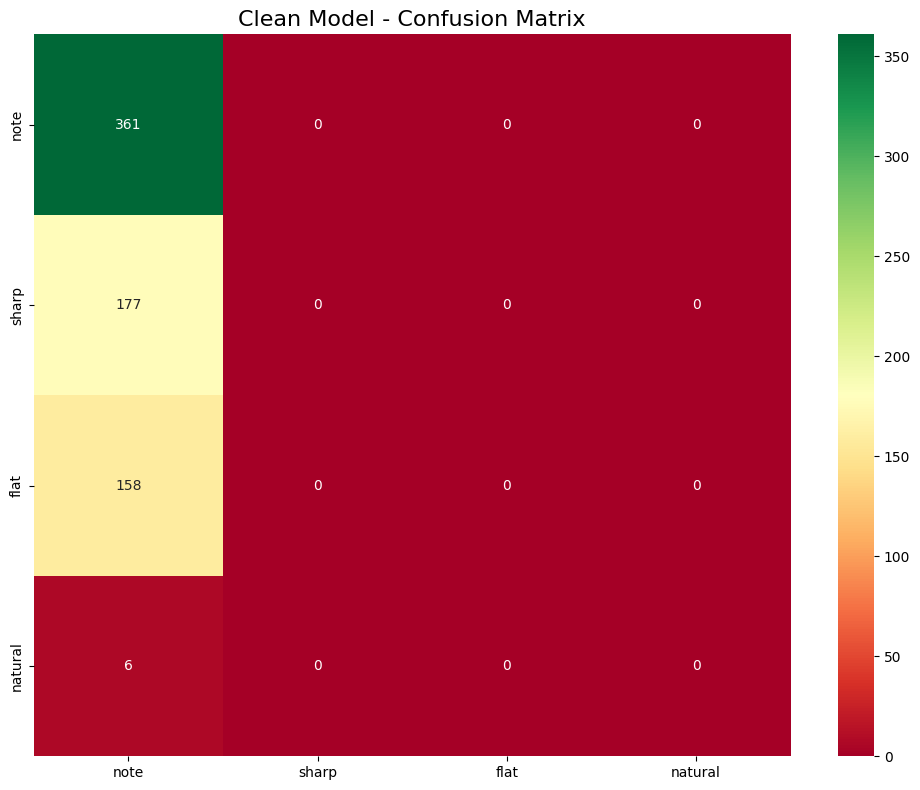

In [ ]:
# ============================================================================
# TWO-STAGE TRAINING
# ============================================================================

import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

# ============================================================================
# CLASS DEFINITIONS
# ============================================================================

class DeepScoresLoader:
    """Loads and parses DeepScores V2 dataset"""

    def __init__(self, dataset_path, split="train"):
        self.dataset_path = Path(dataset_path)
        self.split = split

        self.images_path = self.dataset_path / "images"
        self.annotation_file = self.dataset_path / f"deepscores_{split}.json"

        self.note_classes = {
            'noteheadBlackInSpace': 'note',
            'noteheadBlackOnLine': 'note',
            'noteheadBlackInSpaceSmall': 'note',
            'noteheadBlackOnLineSmall': 'note',
            'noteheadFullSmall': 'note',
            'noteheadHalfInSpace': 'note',
            'noteheadHalfOnLine': 'note',
            'noteheadHalfInSpaceSmall': 'note',
            'noteheadHalfOnLineSmall': 'note',
            'noteheadHalfSmall': 'note',
            'noteheadWhole': 'note',
            'noteheadWholeInSpace': 'note',
            'noteheadWholeOnLine': 'note',
            'noteheadWholeInSpaceSmall': 'note',
            'noteheadWholeOnLineSmall': 'note',
            'noteheadDoubleWholeInSpace': 'note',
            'noteheadDoubleWholeOnLine': 'note',
            'noteheadDoubleWholeInSpaceSmall': 'note',
            'noteheadDoubleWholeOnLineSmall': 'note',
            'accidentalSharp': 'sharp',
            'accidentalSharpSmall': 'sharp',
            'accidentalFlat': 'flat',
            'accidentalFlatSmall': 'flat',
            'accidentalNatural': 'natural',
            'accidentalNaturalSmall': 'natural',
            'accidentalDoubleSharp': 'double_sharp',
            'accidentalDoubleFlat': 'double_flat',
            'keySharp': 'sharp',
            'keyFlat': 'flat',
            'keyNatural': 'natural',
        }

        if not self.images_path.exists():
            raise FileNotFoundError(f"Images directory not found: {self.images_path}")
        if not self.annotation_file.exists():
            raise FileNotFoundError(f"Annotation file not found: {self.annotation_file}")

    def load_annotations(self):
        with open(self.annotation_file, 'r') as f:
            return json.load(f)

    def get_note_annotations(self, annotations):
        filtered = []
        cat_id_to_name = {}

        if 'categories' in annotations:
            categories = annotations['categories']
            if isinstance(categories, dict):
                for cat_id, cat_info in categories.items():
                    if isinstance(cat_info, dict):
                        cat_name = cat_info.get('name', '')
                        cat_id_to_name[str(cat_id)] = cat_name
                        cat_id_to_name[int(cat_id)] = cat_name

        anns = annotations.get('annotations', {})
        if isinstance(anns, dict):
            ann_list = list(anns.values())
        else:
            ann_list = anns

        for ann in ann_list:
            cat_ids = ann.get('cat_id', [])
            if not isinstance(cat_ids, list):
                cat_ids = [cat_ids]

            for cat_id in cat_ids:
                if cat_id in cat_id_to_name:
                    cat_name = cat_id_to_name[cat_id]
                    if cat_name in self.note_classes:
                        ann_copy = ann.copy()
                        ann_copy['symbol_type'] = self.note_classes[cat_name]
                        ann_copy['category_id'] = cat_id
                        filtered.append(ann_copy)
                        break

        return filtered


class NoteDataset:
    """Builds training data with quality filtering"""

    def __init__(self, loader, input_size=32):
        self.loader = loader
        self.input_size = input_size

        self.label_to_idx = {
            'note': 0,
            'sharp': 1,
            'flat': 2,
            'natural': 3,
            'double_sharp': 4,
            'double_flat': 5
        }
        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}

    def extract_crop(self, image, bbox):
        x, y, w, h = map(int, bbox)
        x = max(0, x)
        y = max(0, y)
        crop = image[y:y+h, x:x+w]

        if crop.size == 0 or crop.shape[0] < 1 or crop.shape[1] < 1:
            return None

        crop = cv2.resize(crop, (self.input_size, self.input_size))
        return crop

    def is_valid_training_sample(self, bbox, img_shape, symbol_type):
        """Filter out bad training samples"""
        x, y, w, h = bbox
        img_h, img_w = img_shape[:2]

        # Size filters
        if w < 5 or h < 5:  # Too small
            return False
        if w > img_w * 0.25 or h > img_h * 0.12:  # Too large
            return False

        # Aspect ratio filters
        aspect_ratio = w / h if h > 0 else 0
        if aspect_ratio < 0.2 or aspect_ratio > 4.0:  # Extreme ratios
            return False

        # Symbol-specific filters
        if symbol_type == 'note':
            # Notes should be compact
            if aspect_ratio > 2.5:  # Too wide for a note
                return False
        elif symbol_type in ['sharp', 'flat', 'natural']:
            # Accidentals are usually taller
            if aspect_ratio > 2.0:  # Too wide
                return False

        # Area filter
        area = w * h
        if area < 30 or area > img_w * img_h * 0.015:
            return False

        return True


# ============================================================================
# CONFIGURATION
# ============================================================================
dataset_path = "/content/drive/MyDrive/ds2_dense"
input_size = 32
epochs = 25
batch_size = 128
max_per_class = 5000  # Maximum samples per class
model_save_path = "/content/drive/MyDrive/note_detector_CLEAN.h5"

print("="*60)
print("🎯 TWO-STAGE CLEAN TRAINING 🎯")
print("="*60)
print(f"\n⚡ Configuration:")
print(f"  - Max per class: {max_per_class:,}")
print(f"  - Epochs: {epochs}")
print(f"  - Batch size: {batch_size}")
print(f"  - Quality filtering: ENABLED")
print(f"  - Balanced sampling: ENABLED")

# ============================================================================
# STAGE 1: LOAD AND FILTER DATA
# ============================================================================
print("\n" + "="*60)
print("[STAGE 1] Loading and filtering data...")
print("="*60)

loader = DeepScoresLoader(dataset_path, split="train")
dataset = NoteDataset(loader, input_size=input_size)

print("  [1a] Loading annotations...")
annotations = loader.load_annotations()
note_anns = loader.get_note_annotations(annotations)

print(f"  [1b] Total note annotations: {len(note_anns):,}")

# Build image mapping
img_id_to_filename = {}
img_id_to_shape = {}
if 'images' in annotations:
    images = annotations['images']
    if isinstance(images, list):
        for img in images:
            img_id = img.get('id')
            filename = img.get('filename', img.get('file_name', ''))
            img_id_to_filename[str(img_id)] = filename
            img_id_to_filename[int(img_id)] = filename

            # Store image dimensions for filtering
            img_id_to_shape[str(img_id)] = (img.get('height', 0), img.get('width', 0))
            img_id_to_shape[int(img_id)] = (img.get('height', 0), img.get('width', 0))

# Filter by quality and group by class
print("  [1c] Filtering by quality...")
anns_by_class = defaultdict(list)
filtered_out = 0

for ann in note_anns:
    image_id = ann.get('img_id', ann.get('image_id'))
    bbox = ann.get('a_bbox', ann.get('bbox'))
    symbol_type = ann.get('symbol_type', 'note')

    if bbox is None or image_id not in img_id_to_shape:
        filtered_out += 1
        continue

    img_shape = img_id_to_shape[image_id]

    # Apply quality filter
    if dataset.is_valid_training_sample(bbox, img_shape, symbol_type):
        anns_by_class[symbol_type].append(ann)
    else:
        filtered_out += 1

print(f"  [1d] Filtered out {filtered_out:,} low-quality annotations")

print("\n  📊 High-quality annotations per class:")
for class_name, anns in sorted(anns_by_class.items()):
    print(f"    {class_name}: {len(anns):,}")

# Balanced sampling
print("\n  [1e] Balanced sampling...")
balanced_anns = []
for class_name, anns in anns_by_class.items():
    n_samples = min(max_per_class, len(anns))
    sampled = np.random.choice(anns, size=n_samples, replace=False)
    balanced_anns.extend(sampled)
    print(f"    ✓ Sampled {n_samples:,} from {class_name}")

np.random.shuffle(balanced_anns)
print(f"\n  🎯 Total balanced high-quality samples: {len(balanced_anns):,}")

# ============================================================================
# STAGE 2: BUILD TRAINING DATA
# ============================================================================
print("\n" + "="*60)
print("[STAGE 2] Building training dataset...")
print("="*60)

X = []
y = []
processed = 0
skipped = 0

for i, ann in enumerate(balanced_anns):
    if (i + 1) % 2500 == 0:
        print(f"  Progress: {i+1:,}/{len(balanced_anns):,} ({(i+1)/len(balanced_anns)*100:.1f}%)")

    image_id = ann.get('img_id', ann.get('image_id'))
    if image_id not in img_id_to_filename:
        skipped += 1
        continue

    image_path = loader.images_path / img_id_to_filename[image_id]

    if not image_path.exists():
        skipped += 1
        continue

    img = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        skipped += 1
        continue

    bbox = ann.get('a_bbox', ann.get('bbox'))
    if bbox is None:
        skipped += 1
        continue

    crop = dataset.extract_crop(img, bbox)
    if crop is None:
        skipped += 1
        continue

    X.append(crop)
    y.append(dataset.label_to_idx.get(ann.get('symbol_type', 'note'), 0))
    processed += 1

X = np.array(X).reshape(-1, input_size, input_size, 1)
y = np.array(y, dtype=np.int32)

print(f"\n  ✅ Processed: {processed:,}")
print(f"  ⚠️  Skipped: {skipped:,}")
print(f"  📦 Shape: X={X.shape}, y={y.shape}")

print(f"\n  📊 Final class distribution:")
for class_name, idx in sorted(dataset.label_to_idx.items(), key=lambda x: x[1]):
    count = np.sum(y == idx)
    pct = (count / len(y)) * 100
    bar = "█" * int(pct / 2)
    print(f"    {class_name:15} {count:6,} ({pct:5.1f}%) {bar}")

# ============================================================================
# STAGE 3: BUILD MODEL
# ============================================================================
print("\n" + "="*60)
print("[STAGE 3] Building improved model...")
print("="*60)

data_augmentation = keras.Sequential([
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.12),
    layers.RandomTranslation(0.12, 0.12),
    layers.RandomContrast(0.15),
])

model = keras.Sequential([
    layers.Input(shape=(input_size, input_size, 1)),
    data_augmentation,

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(dataset.label_to_idx), activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# ============================================================================
# STAGE 4: TRAIN
# ============================================================================
print("\n" + "="*60)
print("[STAGE 4] Training...")
print("="*60)

X = X.astype("float32") / 255.0
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, stratify=y, random_state=42
)

print(f"  Training:   {X_train.shape[0]:,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Validation: {X_test.shape[0]:,} ({len(X_test)/len(X)*100:.1f}%)\n")

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6),
    keras.callbacks.ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)

# ============================================================================
# EVALUATION
# ============================================================================
print("\n" + "="*60)
print("[EVALUATION]")
print("="*60)

y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)
acc = accuracy_score(y_test, y_pred)

print(f"\n🎯 Accuracy: {acc:.4f} ({acc*100:.2f}%)\n")

# Get only the classes that actually exist in the data
existing_classes = np.unique(y_test)
existing_class_names = [dataset.idx_to_label[idx] for idx in existing_classes]

print(classification_report(y_test, y_pred, target_names=existing_class_names, digits=4))

# For confusion matrix, only show existing classes
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="RdYlGn",
            xticklabels=existing_class_names,
            yticklabels=existing_class_names)
plt.title("Clean Model - Confusion Matrix", fontsize=16)
plt.tight_layout()
plt.show()